In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Loading original dataset function
def load_dataset(file_location):
    df = pd.read_csv(file_location)
    return df

In [3]:
# loading parquet dataset function
def load_parquet_dataset(parquet_file_location):
    pdf = pd.read_parquet(parquet_file_location)
    return pdf

In [4]:
# load dataset
main_file_location = 'data_dumps/Netflix_dataset.csv'
df = load_dataset(main_file_location)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# Data Exploration Before Pre-processing - Shape And Type Analysis

In [5]:
# Shape of data
shape = df.shape
rows = shape[0]
cols = shape[1]

print(f'Number of rows: {rows} \nNumber of columns: {cols}')

Number of rows: 8807 
Number of columns: 12


In [6]:
# Attribute Analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [7]:
# Missing Value Analysis
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

# Data Pre-processing

## Identifying Nested Data
- In our dataset nested data are columns that have concatenated information using ','
- The check function will be used to identify columns that contain ',' in them

In [8]:
def check_coma(col):
    if df[col].dtype == 'object' and np.any(df[col].str.contains(',')) == True:
        nested_cols.append(col)
        return col


In [9]:
cols = df.columns
nested_cols = []
nested_cols = [check_coma(col) for col in cols if check_coma(col) is not None]
    

In [10]:
print('Check Function Identified these columns that contain \',\':')
for col in nested_cols:
    print(col)

Check Function Identified these columns that contain ',':
title
director
cast
country
date_added
listed_in
description


## Identifying candidates that require un-nesting
- The un-nesting needs to be performed on columns that have multiple data concatenated using ','.
- Let's identify columns that require unnesting from remaining columns

In [11]:
for col in nested_cols:
    print(f'Checking values that contain \',\' in {col.upper()}')
    data = df[(df[col].str.contains(',')) & (df[col].isna()==False)][col].sample(10)
    print(data)
    print('-'*20)
    print()

Checking values that contain ',' in TITLE
5164    Jim & Andy: The Great Beyond - Featuring a Ver...
10                    Vendetta: Truth, Lies and The Mafia
6304                             Big Dreams, Small Spaces
5572                                     Bon Cop, Bad Cop
7011                          Houston, We Have a Problem!
4128            Ray Romano: Right Here, Around the Corner
5981                                          10,000 B.C.
2521                                   I love you, stupid
6182                                           Aram, Aram
2951                                   Faith, Hope & Love
Name: title, dtype: object
--------------------

Checking values that contain ',' in DIRECTOR
7740                          Dana Nachman, Don Hardy Jr.
1635                              Stanley Moore, Alex Woo
201                            Anil V. Kumar, Anurag Basu
4897                     Guillermo Garcia, David Cantolla
6624    Mahin Ibrahim, Austin Kolodney, Will Lowell,

- **Title:** Doesn't require un-nesting as ',' is for grammatical purpose.
- **Director:** Requires un-nesting as ',' is used to separate multiple data.
- **Cast:** Requires un-nesting as ',' is used to separate multiple data.
- **Country:** Requires un-nesting as ',' is used to separate multiple data.
- **Date Added:** Doesn't require un-nesting as ',' is to create date.
- **Listed In:** Requires un-nesting as ',' is used to separate multiple data.
- **Description:** Doesn't require un-nesting as ',' is for grammatical purpose.

**The identified candidates for un-nesting are:**
- Director
- Cast
- Country
- Listed_in

## Un-nesting identified columns
**The Un-nesting will be performed in following steps:**
- **Step 1:** Create a copy of original dataframe.
- **Step 2:** Prepare nested columns for split.
- **Step 3:** Split Values:
    - First check: check if the values are already in the form of a list. If yes then ignore. This is necessary in order to maintain data integrity.
    - Second check:check if the function contains ','. If yes it will split the data into a list.
    - Third check: if the column contains null value it will create a list with np.nan() to maintain the data integrity.
- **Step 4:** Add the split values.
- **Step 5:** Explode data using pandas explode function in separate dataframes and dropping irrelevant columns.
    

### Step 1: Create a copy of original dataframe.

In [12]:
# Creating a copy of original df
df_to_exp = df.copy()
df_to_exp.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### **Step 2:** Prepare nested columns for split.

In [13]:
# prepare columns and rows for un-nesting
unnest_cols = ['director', 'cast', 'country', 'listed_in']
rows = df_to_exp.shape[0]
rows

8807

### Step 3: Split Values

In [14]:
# split function
def split_cols(value, row_ind, df):
    row_value = df[value][row_ind]
    dt_type = type(row_value)
    if 'list' in str(dt_type):
        return df
        
    elif ',' in str(row_value):
        df[value][row_ind] = str(row_value).split(',')
        
    elif 'nan' in str(row_value):
        df[value][row_ind] = np.nan
        
    else:
        df[value][row_ind] = [row_value]
        
    return df

In [15]:
# calling split function
for row_ind in range(rows):
    for col in unnest_cols:
        val = col
        ind = row_ind
        df_to_exp = split_cols(val, ind, df_to_exp)

print(f'Split Successful')

Split Successful


In [16]:
df_to_exp.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,[Kirsten Johnson],NaN,[United States],"September 25, 2021",2020,PG-13,90 min,[Documentaries],"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"[Ama Qamata, Khosi Ngema, Gail Mabalane, Th...",[South Africa],"September 24, 2021",2021,TV-MA,2 Seasons,"[International TV Shows, TV Dramas, TV Myste...","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,[Julien Leclercq],"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, ...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"[Crime TV Shows, International TV Shows, TV ...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"[Docuseries, Reality TV]","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"[Mayur More, Jitendra Kumar, Ranjan Raj, Al...",[India],"September 24, 2021",2021,TV-MA,2 Seasons,"[International TV Shows, Romantic TV Shows, ...",In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,[Mike Flanagan],"[Kate Siegel, Zach Gilford, Hamish Linklater...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"[TV Dramas, TV Horror, TV Mysteries]",The arrival of a charismatic young priest brin...
6,s7,Movie,My Little Pony: A New Generation,"[Robert Cullen, JosÃ© Luis Ucha]","[Vanessa Hudgens, Kimiko Glenn, James Marsde...",NaN,"September 24, 2021",2021,PG,91 min,[Children & Family Movies],Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,[Haile Gerima],"[Kofi Ghanaba, Oyafunmike Ogunlano, Alexandr...","[United States, Ghana, Burkina Faso, United...","September 24, 2021",1993,TV-MA,125 min,"[Dramas, Independent Movies, International M...","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,[Andy Devonshire],"[Mel Giedroyc, Sue Perkins, Mary Berry, Pau...",[United Kingdom],"September 24, 2021",2021,TV-14,9 Seasons,"[British TV Shows, Reality TV]",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,[Theodore Melfi],"[Melissa McCarthy, Chris O'Dowd, Kevin Kline...",[United States],"September 24, 2021",2021,PG-13,104 min,"[Comedies, Dramas]",A woman adjusting to life after a loss contend...


In [17]:
df_to_exp.shape

(8807, 12)

### Step 5: Explode columns using pandas explode function and drop irrelevant columns.

In [18]:
og_df = df[['show_id', 'type', 'title', 'date_added', 'release_year', 'rating', 'duration', 'description']]

In [19]:
og_df.head(10)

,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,"September 25, 2021",2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,"September 24, 2021",2021,TV-MA,1 Season,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,"September 24, 2021",2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,"September 24, 2021",2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,"September 24, 2021",2021,TV-MA,1 Season,The arrival of a charismatic young priest brin...
6,s7,Movie,My Little Pony: A New Generation,"September 24, 2021",2021,PG,91 min,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,"September 24, 2021",1993,TV-MA,125 min,"On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,"September 24, 2021",2021,TV-14,9 Seasons,A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,"September 24, 2021",2021,PG-13,104 min,A woman adjusting to life after a loss contend...


In [20]:
# exploding director
dir_df = df_to_exp.copy()
dir_df = dir_df[['show_id', 'director']]
dir_df = dir_df.explode('director', ignore_index=True)
dir_df.head(20)

,show_id,director
0,s1,Kirsten Johnson
1,s2,NaN
2,s3,Julien Leclercq
3,s4,NaN
4,s5,NaN
5,s6,Mike Flanagan
6,s7,Robert Cullen
7,s7,JosÃ© Luis Ucha
8,s8,Haile Gerima
9,s9,Andy Devonshire


In [21]:
# exploding cast
cast_df = df_to_exp.copy()
cast_df = cast_df[['show_id', 'cast']]
cast_df = cast_df.explode('cast', ignore_index=True)
cast_df.head(5)

,show_id,cast
0,s1,NaN
1,s2,Ama Qamata
2,s2,Khosi Ngema
3,s2,Gail Mabalane
4,s2,Thabang Molaba


In [22]:
# exploding country
country_df = df_to_exp.copy()
country_df = country_df[['show_id', 'country']]
country_df = country_df.explode('country', ignore_index=True)
country_df.head(5)

,show_id,country
0,s1,United States
1,s2,South Africa
2,s3,NaN
3,s4,NaN
4,s5,India


In [23]:
# exploding listed_in
listed_in_df = df_to_exp.copy()
listed_in_df = listed_in_df[['show_id', 'listed_in']]
listed_in_df = listed_in_df.explode('listed_in', ignore_index=True)
listed_in_df.head(5)

,show_id,listed_in
0,s1,Documentaries
1,s2,International TV Shows
2,s2,TV Dramas
3,s2,TV Mysteries
4,s3,Crime TV Shows


## Removing leading and trailing spaces from each column

In [24]:
def trim(exp_df):
    columns = exp_df.columns
    for col in columns:
        if exp_df[col].dtype == 'O':
            try:
                exp_df[col] = exp_df[col].str.strip()
                print(f'Trim operation for {col.upper()} was a success')

            except Exception as e:
                print(f'An error occurred for {col.upper()}: {str(e)}')

        else:
            print(f'Skipping non-string column {col.upper()}')
    
    return exp_df
        

In [25]:
og_df = trim(og_df)
og_df.head()

Trim operation for SHOW_ID was a success
Trim operation for TYPE was a success
Trim operation for TITLE was a success
Trim operation for DATE_ADDED was a success
Skipping non-string column RELEASE_YEAR
Trim operation for RATING was a success
Trim operation for DURATION was a success
Trim operation for DESCRIPTION was a success


,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,"September 25, 2021",2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,"September 24, 2021",2021,TV-MA,1 Season,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,"September 24, 2021",2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,"September 24, 2021",2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...


In [26]:
dir_df = trim(dir_df)
dir_df.head()

Trim operation for SHOW_ID was a success
Trim operation for DIRECTOR was a success


,show_id,director
0,s1,Kirsten Johnson
1,s2,NaN
2,s3,Julien Leclercq
3,s4,NaN
4,s5,NaN


In [27]:
cast_df = trim(cast_df)
cast_df.head()

Trim operation for SHOW_ID was a success
Trim operation for CAST was a success


,show_id,cast
0,s1,NaN
1,s2,Ama Qamata
2,s2,Khosi Ngema
3,s2,Gail Mabalane
4,s2,Thabang Molaba


In [28]:
country_df = trim(country_df)
country_df.head()

Trim operation for SHOW_ID was a success
Trim operation for COUNTRY was a success


,show_id,country
0,s1,United States
1,s2,South Africa
2,s3,NaN
3,s4,NaN
4,s5,India


In [29]:
listed_in_df = trim(listed_in_df)
listed_in_df.head()

Trim operation for SHOW_ID was a success
Trim operation for LISTED_IN was a success


,show_id,listed_in
0,s1,Documentaries
1,s2,International TV Shows
2,s2,TV Dramas
3,s2,TV Mysteries
4,s3,Crime TV Shows


## Handling Missing Values
In our raw dataset, following columns have missing values:
- **director:** 2634
- **cast:** 825
- **country:** 831
- **date_added:** 10
- **rating:** 4
- **duration:** 3

### Imputing Missing Values
- **director:** Replacing nan with Unknown Director
- **cast:** Replacing nan with Unknown Actor
- **country:** Replacing nan with Unknown Country
- **rating:** Replacing nan with Unknown Rating
- **duration:** Replacing nan with 0.


In [30]:
og_df['rating'] = og_df['rating'].fillna('Unknown Rating')
og_df['duration'] = og_df['duration'].fillna('0')

In [31]:
og_df.isna().sum()

show_id          0
type             0
title            0
date_added      10
release_year     0
rating           0
duration         0
description      0
dtype: int64

In [32]:
dir_df['director'] = dir_df['director'].fillna('Unknown Director')
dir_df.isna().sum()

show_id     0
director    0
dtype: int64

In [33]:
cast_df['cast'] = cast_df['cast'].fillna('Unknown Actor')
cast_df.isna().sum()

show_id    0
cast       0
dtype: int64

In [34]:
country_df['country'] = country_df['country'].fillna('Unknown Country')
country_df.isna().sum()

show_id    0
country    0
dtype: int64

In [35]:
listed_in_df['listed_in'] = listed_in_df['listed_in'].fillna('Unknown Tag')
listed_in_df.isna().sum()

show_id      0
listed_in    0
dtype: int64

## Converting date from string to date datatype in dd/mm/yyy format


In [36]:
og_df.head()

,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,"September 25, 2021",2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,"September 24, 2021",2021,TV-MA,1 Season,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,"September 24, 2021",2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,"September 24, 2021",2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...


In [37]:
og_df.shape

(8807, 8)

In [38]:
try:
    # Convert 'date_added' to datetime
    og_df['date_added'] = pd.to_datetime(og_df['date_added'], format='%B %d, %Y').dt.strftime('%d-%m-%Y')
except ValueError as e:
    # Handle the error, for example, replace with a default date
    print(f"An error occurred: {e}")

In [39]:
og_df.head()

,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...


In [40]:
og_df['date_added'] = pd.to_datetime(og_df['date_added'])

In [41]:
og_df['date_added'] = og_df['date_added'].dt.strftime('%d-%m-%Y')

In [42]:
og_df.head()

,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...


# DATA FORM EXPLORATION – SHAPE AND TYPE ANALYSIS

## Shape of Dataframes

In [43]:
# Shape of original dataframe
shape = og_df.shape
rows = shape[0]
cols = shape[1]

print(f'Number of rows: {rows} \nNumber of columns: {cols}')

Number of rows: 8807 
Number of columns: 8


In [44]:
# Shape of director dataframe
shape = dir_df.shape
rows = shape[0]
cols = shape[1]

print(f'Number of rows: {rows} \nNumber of columns: {cols}')

Number of rows: 9612 
Number of columns: 2


In [45]:
# Shape of cast dataframe
shape = cast_df.shape
rows = shape[0]
cols = shape[1]

print(f'Number of rows: {rows} \nNumber of columns: {cols}')

Number of rows: 64951 
Number of columns: 2


In [46]:
# Shape of country dataframe
shape = country_df.shape
rows = shape[0]
cols = shape[1]

print(f'Number of rows: {rows} \nNumber of columns: {cols}')

Number of rows: 10850 
Number of columns: 2


In [47]:
# Shape of listed tags dataframe
shape = listed_in_df.shape
rows = shape[0]
cols = shape[1]

print(f'Number of rows: {rows} \nNumber of columns: {cols}')

Number of rows: 19323 
Number of columns: 2


## Dataframe Attribute Analysis

In [48]:
# Attributes of original dataframe
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   date_added    8797 non-null   object
 4   release_year  8807 non-null   int64 
 5   rating        8807 non-null   object
 6   duration      8807 non-null   object
 7   description   8807 non-null   object
dtypes: int64(1), object(7)
memory usage: 550.6+ KB


In [49]:
# Attributes of director dataframe
dir_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9612 entries, 0 to 9611
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   show_id   9612 non-null   object
 1   director  9612 non-null   object
dtypes: object(2)
memory usage: 150.3+ KB


In [50]:
# Attributes of cast dataframe
cast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64951 entries, 0 to 64950
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   show_id  64951 non-null  object
 1   cast     64951 non-null  object
dtypes: object(2)
memory usage: 1015.0+ KB


In [51]:
# Attributes of country dataframe
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   show_id  10850 non-null  object
 1   country  10850 non-null  object
dtypes: object(2)
memory usage: 169.7+ KB


In [52]:
# Attributes of listed in tags dataframe
listed_in_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19323 entries, 0 to 19322
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   show_id    19323 non-null  object
 1   listed_in  19323 non-null  object
dtypes: object(2)
memory usage: 302.1+ KB


## Attribute Diversity Check

### Tv Shows vs Movies

In [53]:
content_type = og_df['type'].value_counts()
print(f'There are {content_type[0]} movies and {content_type[1]} TV shows in the dataset')

There are 6131 movies and 2676 TV shows in the dataset


**With 6131 movies and 2676 TV shows, the dataset showcases a diverse collection of content.**

### Directors of TV Shows vs. Movies

In [54]:
merged_df = og_df.merge(dir_df, on='show_id', how='inner')
merged_df.head()

,show_id,type,title,date_added,release_year,rating,duration,description,director
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm...",Kirsten Johnson
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",Unknown Director
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,Julien Leclercq
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo...",Unknown Director
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,Unknown Director


In [55]:
# TV Directors 
tvd = merged_df.loc[merged_df['type'] == 'TV Show', ['director']].nunique()

# movie directors
mvd = merged_df.loc[merged_df['type'] == 'Movie', ['director']].nunique()

# Total directors
td = mvd + tvd

print(f'Total number of directors: {td.values[0]}')
print(f'Number of directors directing the movies: {mvd.values[0]}')
print(f'Number of directors directing TV Shows: {tvd.values[0]}')


Total number of directors: 5040
Number of directors directing the movies: 4742
Number of directors directing TV Shows: 298


### Cast of TV Shows vs. Movies

In [56]:
merged_df = og_df.merge(cast_df, on='show_id', how='inner')

# TV Directors 
tvc = merged_df.loc[merged_df['type'] == 'TV Show', ['cast']].nunique()

# movie directors
mvc = merged_df.loc[merged_df['type'] == 'Movie', ['cast']].nunique()

# Total directors
tc = mvc + tvc

print(f'Total number of actors: {tc.values[0]}')
print(f'Number of casts acting in the movies: {mvc.values[0]}')
print(f'Number of casts acting in TV Shows: {tvc.values[0]}')

Total number of actors: 40809
Number of casts acting in the movies: 25947
Number of casts acting in TV Shows: 14862


### Country wise TV Shows vs. Movies

In [378]:
merged_df = og_df.merge(country_df, on='show_id', how='inner')

# TV Directors 
tvc = merged_df.loc[merged_df['type'] == 'TV Show', ['country']].nunique()

# movie directors
mvc = merged_df.loc[merged_df['type'] == 'Movie', ['country']].nunique()

# Total directors
tc = merged_df['country'].nunique()

print(f'Total number of countries: {tc}')
print(f'Number of Countries with Movies: {mvc.values[0]}')
print(f'Number of Countries with TV Shows: {tvc.values[0]}')

Total number of countries: 124
Number of Countries with Movies: 119
Number of Countries with TV Shows: 67


### Genre in Movies

In [380]:
merged_df = og_df.merge(listed_in_df, on='show_id', how='inner')
merged_df.head()

,show_id,type,title,date_added,release_year,rating,duration,description,listed_in
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm...",Documentaries
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",International TV Shows
2,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",TV Dramas
3,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",TV Mysteries
4,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,Crime TV Shows


In [59]:
movie_genre = merged_df.loc[merged_df['type'] == 'Movie', ['listed_in']].value_counts()
print(movie_genre)

listed_in               
International Movies        2752
Dramas                      2427
Comedies                    1674
Documentaries                869
Action & Adventure           859
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Horror Movies                357
Stand-Up Comedy              343
Sci-Fi & Fantasy             243
Sports Movies                219
Classic Movies               116
LGBTQ Movies                 102
Cult Movies                   71
Anime Features                71
Faith & Spirituality          65
Movies                        57
dtype: int64


###  Genre in TV Shows

In [382]:
tv_genre = merged_df.loc[merged_df['type'] == 'TV Show', ['listed_in']].value_counts()
print(tv_genre)

listed_in                   
International TV Shows          1351
TV Dramas                        763
TV Comedies                      581
Crime TV Shows                   470
Kids' TV                         451
Docuseries                       395
Romantic TV Shows                370
Reality TV                       255
British TV Shows                 253
Anime Series                     176
Spanish-Language TV Shows        174
TV Action & Adventure            168
Korean TV Shows                  151
TV Mysteries                      98
Science & Nature TV               92
TV Sci-Fi & Fantasy               84
TV Horror                         75
Teen TV Shows                     69
TV Thrillers                      57
Stand-Up Comedy & Talk Shows      56
Classic & Cult TV                 28
TV Shows                          16
dtype: int64


# Data Visualization

## Countplot (Count of Movies in Each Genre)

In [61]:
movie_genre = movie_genre.reset_index(name='count')

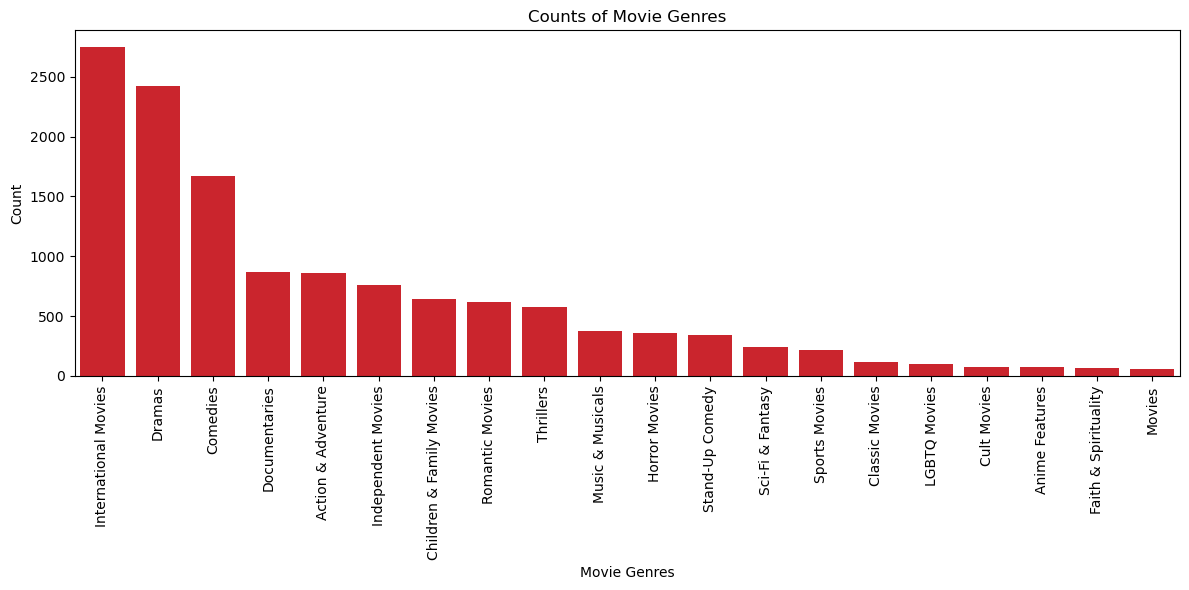

<Figure size 640x480 with 0 Axes>

In [383]:
# Plotting the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='listed_in', y='count', data=movie_genre, color='#E50914')
plt.xlabel('Movie Genres')
plt.ylabel('Count')
plt.title('Counts of Movie Genres')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig('Counts of Movie Genres.png')

**Insight:** In movies, International movies, Dramas, and Comedies are top 3 genres in the entire dataset

## Countplot (Count of TV Shows in Each Genre)

In [63]:
tv_genre_counts = tv_genre.reset_index(name='count')

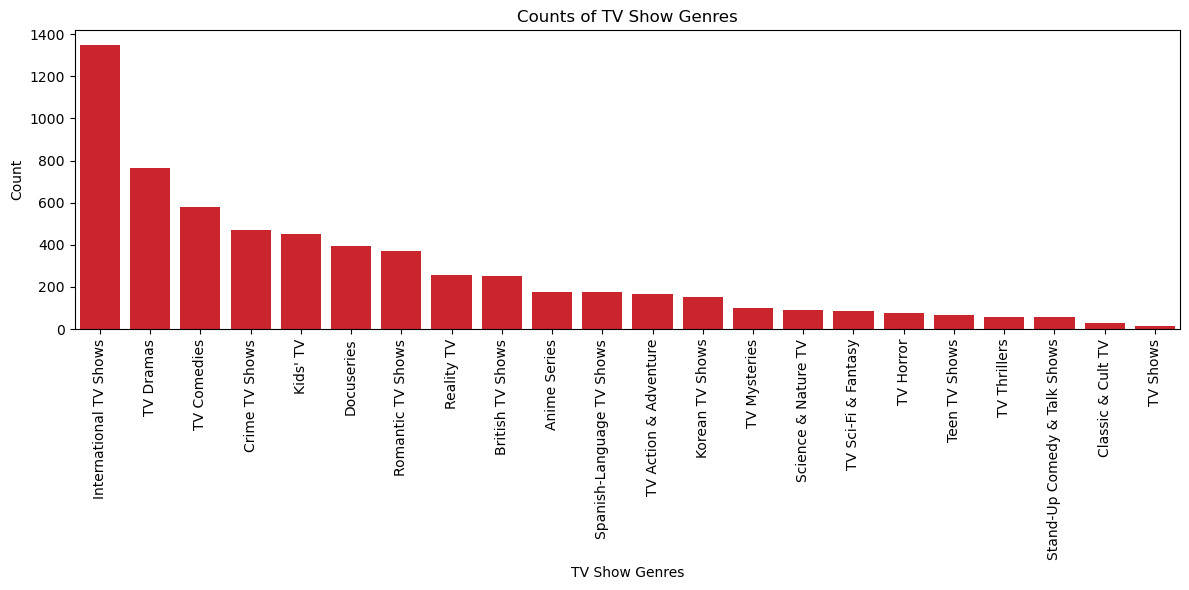

In [64]:
# Plotting the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='listed_in', y='count', data=tv_genre_counts, color='#E50914')
plt.xlabel('TV Show Genres')
plt.ylabel('Count')
plt.title('Counts of TV Show Genres')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Insight:** 
- In TV Shows, International TV Shows, TV Dramas, and TV Comedies are top 3 genres in the entire dataset.
- It is interesting to see that both TV Shows and Movies have same top 3 genres.

## Barplot (Count of Movies Over Release Year)

In [65]:
movies_over_year = og_df[og_df['type'] == 'Movie']
movies_over_year = movies_over_year.groupby('release_year').aggregate(count = ('show_id', 'count')).reset_index()
movies_over_year

,release_year,count
0,1942,2
1,1943,3
2,1944,3
3,1945,3
4,1946,1
...,...,...
68,2017,767
69,2018,767
70,2019,633
71,2020,517


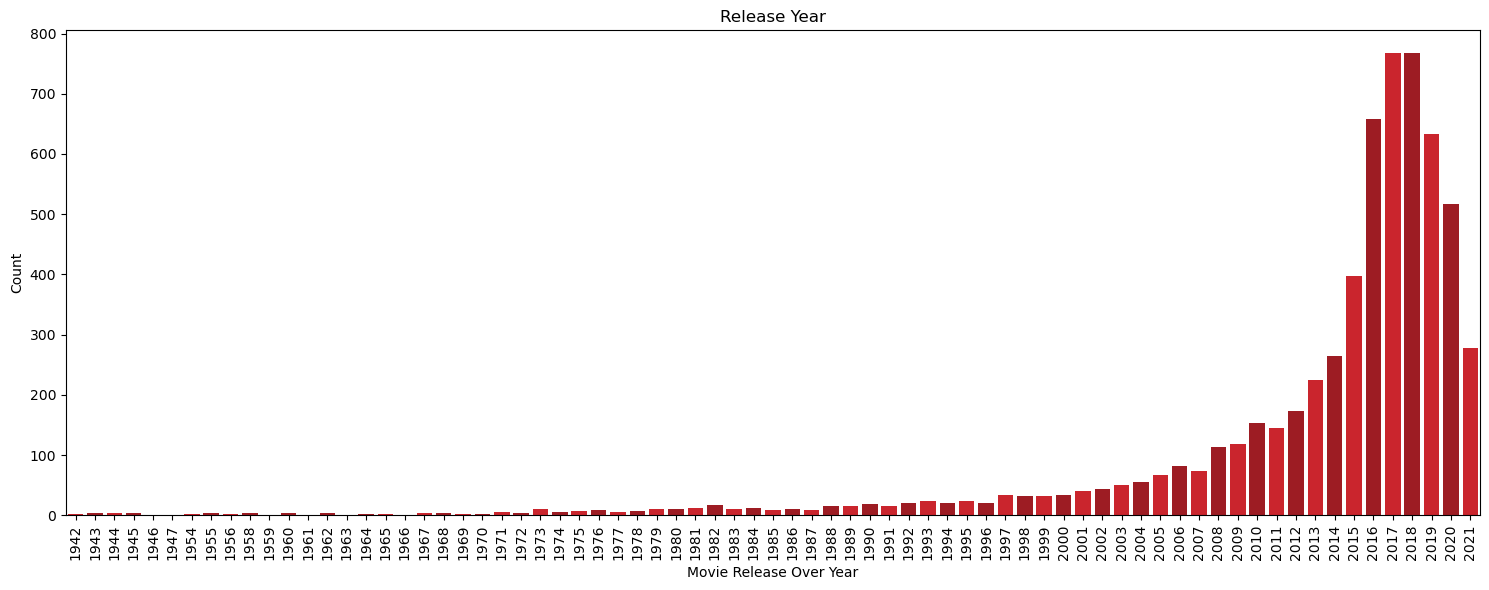

In [66]:
netflix = ["#E50914", "#B20710"]
# Plotting the bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='release_year', y='count', data=movies_over_year, palette=netflix)
plt.xlabel('Movie Release Over Year')
plt.ylabel('Count')
plt.title('Release Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Insight:** The Netflix platform predominantly features a higher number of movies that were released between 2016 and 2019. In contrast, there is a relatively smaller selection of movies released in the years before 2016

## Barplot (Count of TV Shows Over Release Year)

In [67]:
tv_over_year = og_df[og_df['type'] == 'TV Show']
tv_over_year = tv_over_year.groupby('release_year').aggregate(count = ('show_id', 'count')).reset_index()
tv_over_year

,release_year,count
0,1925,1
1,1945,1
2,1946,1
3,1963,1
4,1967,1
5,1972,1
6,1974,1
7,1977,1
8,1979,1
9,1981,1


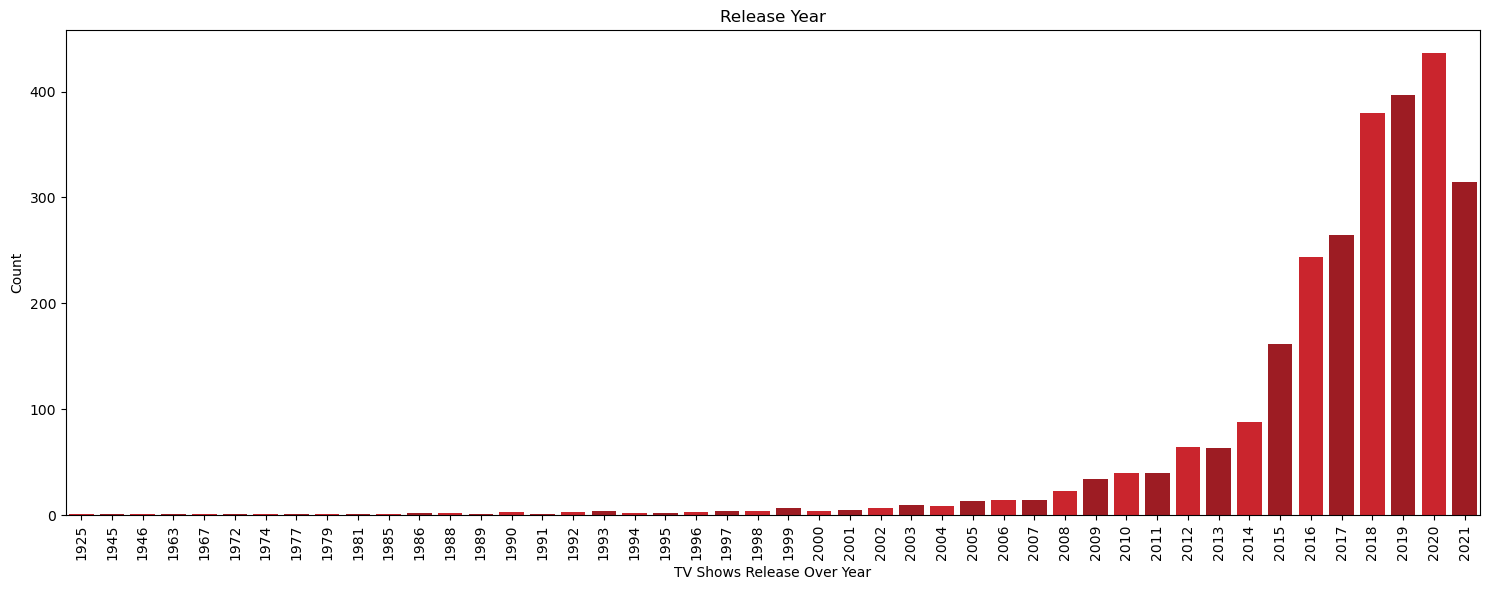

In [68]:
# Plotting the bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='release_year', y='count', data=tv_over_year, palette=netflix)
plt.xlabel('TV Shows Release Over Year')
plt.ylabel('Count')
plt.title('Release Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Insight:** The Netflix platform predominantly features a higher number of TV Shows that were released after 2018.

## Histplot (Distribution of Movie Duration)

In [69]:
movie_duration = og_df[og_df['type'] == 'Movie']
movie_duration.head()

,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm..."
6,s7,Movie,My Little Pony: A New Generation,24-09-2021,2021,PG,91 min,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125 min,"On a photo shoot in Ghana, an American model s..."
9,s10,Movie,The Starling,24-09-2021,2021,PG-13,104 min,A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,23-09-2021,2021,TV-MA,127 min,After most of her family is murdered in a terr...


In [70]:
movie_duration['duration'] = movie_duration['duration'].str.strip(' min').astype(int)
movie_duration.sample(20)

,show_id,type,title,date_added,release_year,rating,duration,description
6171,s6172,Movie,Ant-Man and the Wasp,29-01-2019,2018,PG-13,118,"Problems big and small pop up when Scott Lang,..."
7979,s7980,Movie,Secrets of Westminster,22-04-2017,2014,TV-PG,55,"Take an insider's tour of Parliament, Big Ben ..."
2398,s2399,Movie,Okko's Inn,06-12-2020,2018,PG,96,"After losing her parents, a young girl learns ..."
6028,s6029,Movie,A Billion Colour Story,04-01-2018,2016,TV-14,104,The curious child of idealistic interfaith par...
1122,s1123,Movie,Madam Chief Minister,04-01-2021,2020,TV-14,121,Rising from disadvantage to become a state lea...
8587,s8588,Movie,Thunderbolt,31-03-2017,1947,TV-PG,42,A P-47 Thunderbolt squadron is shown in prepar...
6715,s6716,Movie,Evolution,20-11-2019,2001,PG-13,102,After two community college geology professors...
2532,s2533,Movie,Dilan 1991,14-05-2020,2019,TV-14,118,Dilan's involvement in the motorbike gang impe...
6561,s6562,Movie,Danny Says,03-02-2017,2015,TV-MA,103,This documentary profiles eccentric publicist ...
8018,s8019,Movie,Silent Hill: Revelation,13-12-2019,2012,R,94,Haunted by nightmares and her father's disappe...


In [71]:
movie_duration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6131 entries, 0 to 8806
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6131 non-null   object
 1   type          6131 non-null   object
 2   title         6131 non-null   object
 3   date_added    6131 non-null   object
 4   release_year  6131 non-null   int64 
 5   rating        6131 non-null   object
 6   duration      6131 non-null   int64 
 7   description   6131 non-null   object
dtypes: int64(2), object(6)
memory usage: 431.1+ KB


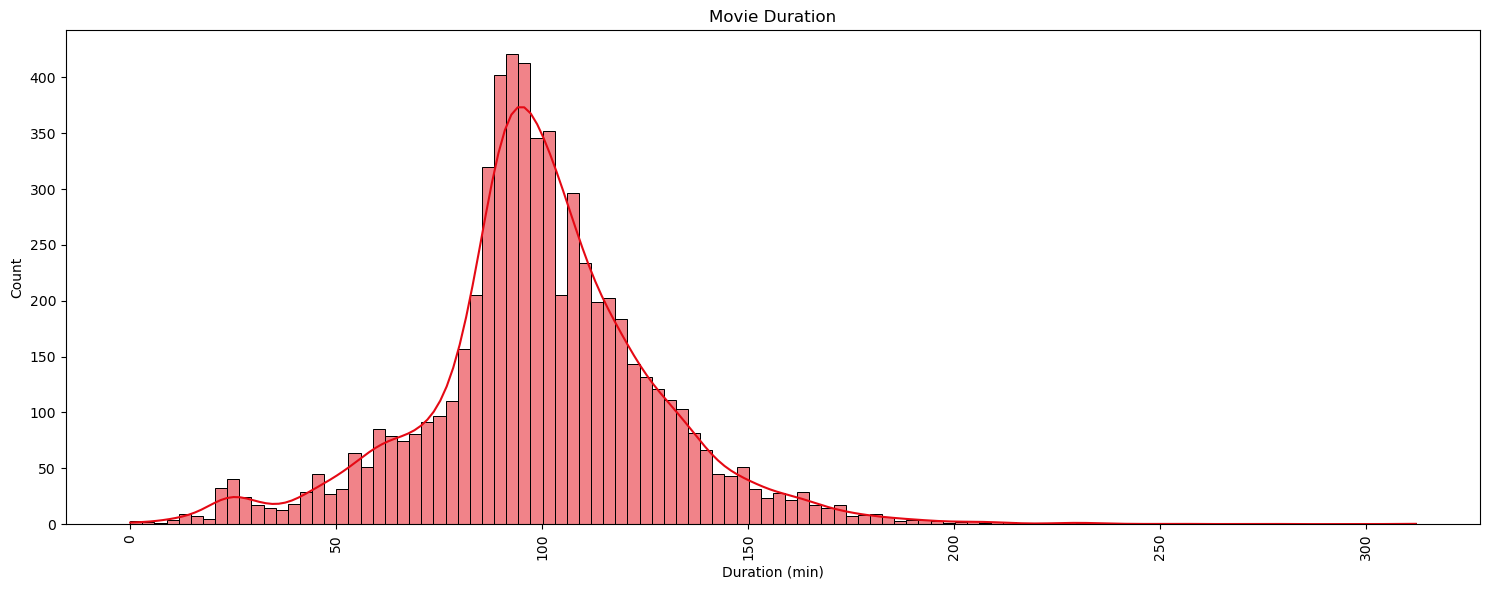

In [72]:
# Plotting the histogram
plt.figure(figsize=(15, 6))
sns.histplot(data=movie_duration['duration'], kde=True, color=netflix[0])
plt.xlabel('Duration (min)')
plt.ylabel('Count')
plt.title('Movie Duration')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Insight:** Most movies listed on the Netflix platform are having duration between 90 mins to 120 mins.

## Histplot (Distribution of TV Show Seasons)

In [73]:
tv_show_duration = og_df[og_df['type'] == 'TV Show']
tv_show_duration.head()

,show_id,type,title,date_added,release_year,rating,duration,description
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,24-09-2021,2021,TV-MA,1 Season,The arrival of a charismatic young priest brin...


In [74]:
tv_show_duration['duration'] = tv_show_duration['duration'].str.strip('\s*Seasons*').astype(int)
tv_show_duration.sample(20)

,show_id,type,title,date_added,release_year,rating,duration,description
1317,s1318,TV Show,Nadiya Bakes,02-12-2021,2021,TV-G,1,Delightful cakes and heavenly breads pop from ...
6750,s6751,TV Show,Filinta,15-04-2017,2015,TV-14,2,"In 19th-century Istanbul, a young police offic..."
1129,s1130,TV Show,Secrets of Great British Castles,04-01-2021,2016,TV-PG,2,Join historian Dan Jones on a journey back in ...
65,s66,TV Show,Numberblocks,15-09-2021,2021,TV-Y,6,"In a place called Numberland, math adds up to ..."
3065,s3066,TV Show,Messiah,01-01-2020,2020,TV-MA,1,A wary CIA officer investigates a charismatic ...
7257,s7258,TV Show,La Rosa de Guadalupe,15-01-2019,2010,TV-PG,1,This series responds to the need to believe in...
2160,s2161,TV Show,Ever After High,08-06-2020,2016,TV-Y7,5,The kids of fairy-tale characters attend a sch...
1181,s1182,TV Show,Country Comfort,19-03-2021,2021,TV-PG,1,"After hitting the skids in her career, an aspi..."
2405,s2406,TV Show,DC's Legends of Tomorrow,06-10-2020,2020,TV-14,5,"A mysterious ""time master"" from the future uni..."
2085,s2086,TV Show,I AM A KILLER: RELEASED,28-08-2020,2020,TV-MA,1,"In this crime docuseries spinoff, a convict is..."


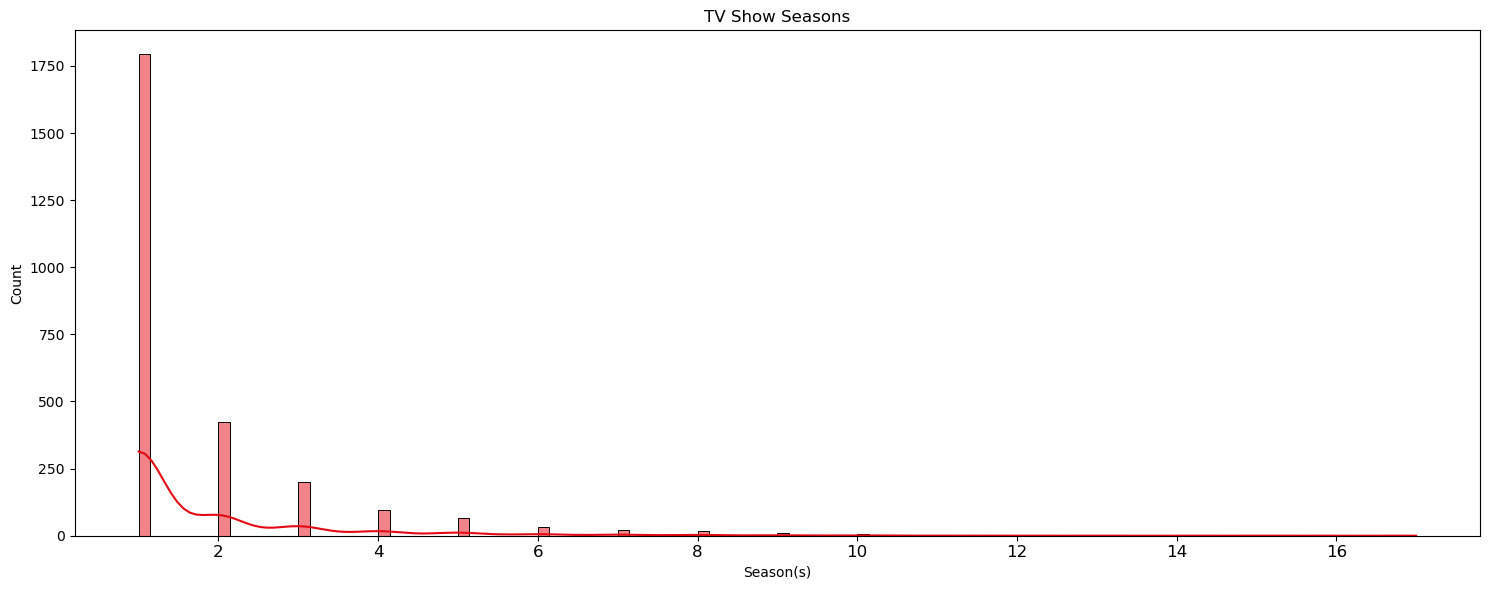

In [75]:
# Plotting the histogram
plt.figure(figsize=(15, 6))
sns.histplot(data=tv_show_duration['duration'], kde=True, color=netflix[0])
plt.xlabel('Season(s)')
plt.ylabel('Count')
plt.title('TV Show Seasons')
plt.xticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

**Insight:** Most TV Shows listed on the Netflix platform have only 1 season.

## Barplot (Movie and TV Show Count by Rating)

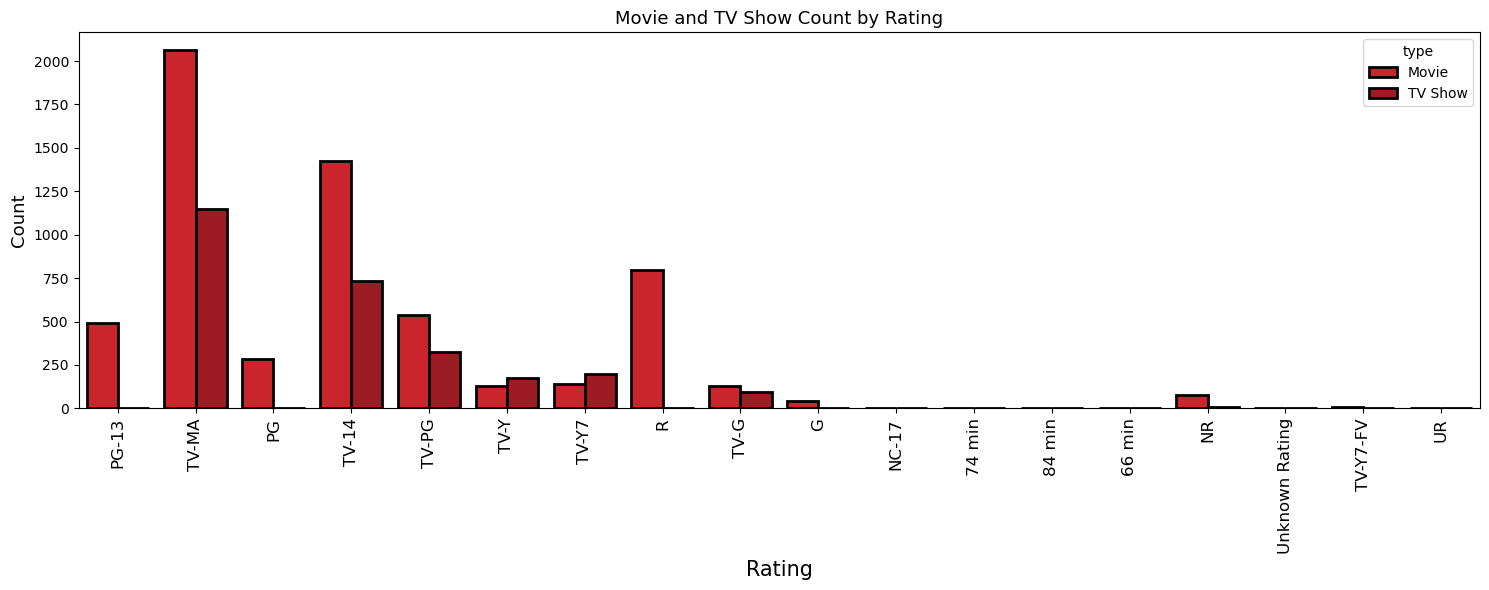

In [76]:
# Plotting the bar plot
plt.figure(figsize=(15, 6))
sns.countplot(x='rating', hue='type', data=og_df, palette=netflix, edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=13)
plt.title('Movie and TV Show Count by Rating', fontsize=13)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

**Insight:** 
- Most movies listed on the Netflix platform have TV-MA rating followed by TV-14 rating.
- Most TV shows listed on the Netflix platform have TV-MA rating followed by TV-14 rating.
- R-rated movies are quite prevalent as compared to TV shows

## Barplot (Multi Country Movie Releases)

In [77]:
merged_country = og_df.merge(country_df, on='show_id', how='inner')
merged_country = merged_country.loc[merged_country['type'] == 'Movie', ['title', 'country']]
merged_country.head()

,title,country
0,Dick Johnson Is Dead,United States
6,My Little Pony: A New Generation,Unknown Country
7,Sankofa,United States
8,Sankofa,Ghana
9,Sankofa,Burkina Faso


In [78]:
top_mtitles_country = merged_country.groupby('title').aggregate(count = ('country', 'count')).sort_values(by='count', ascending=False).reset_index()
top_mtitles_country = top_mtitles_country.head(20)

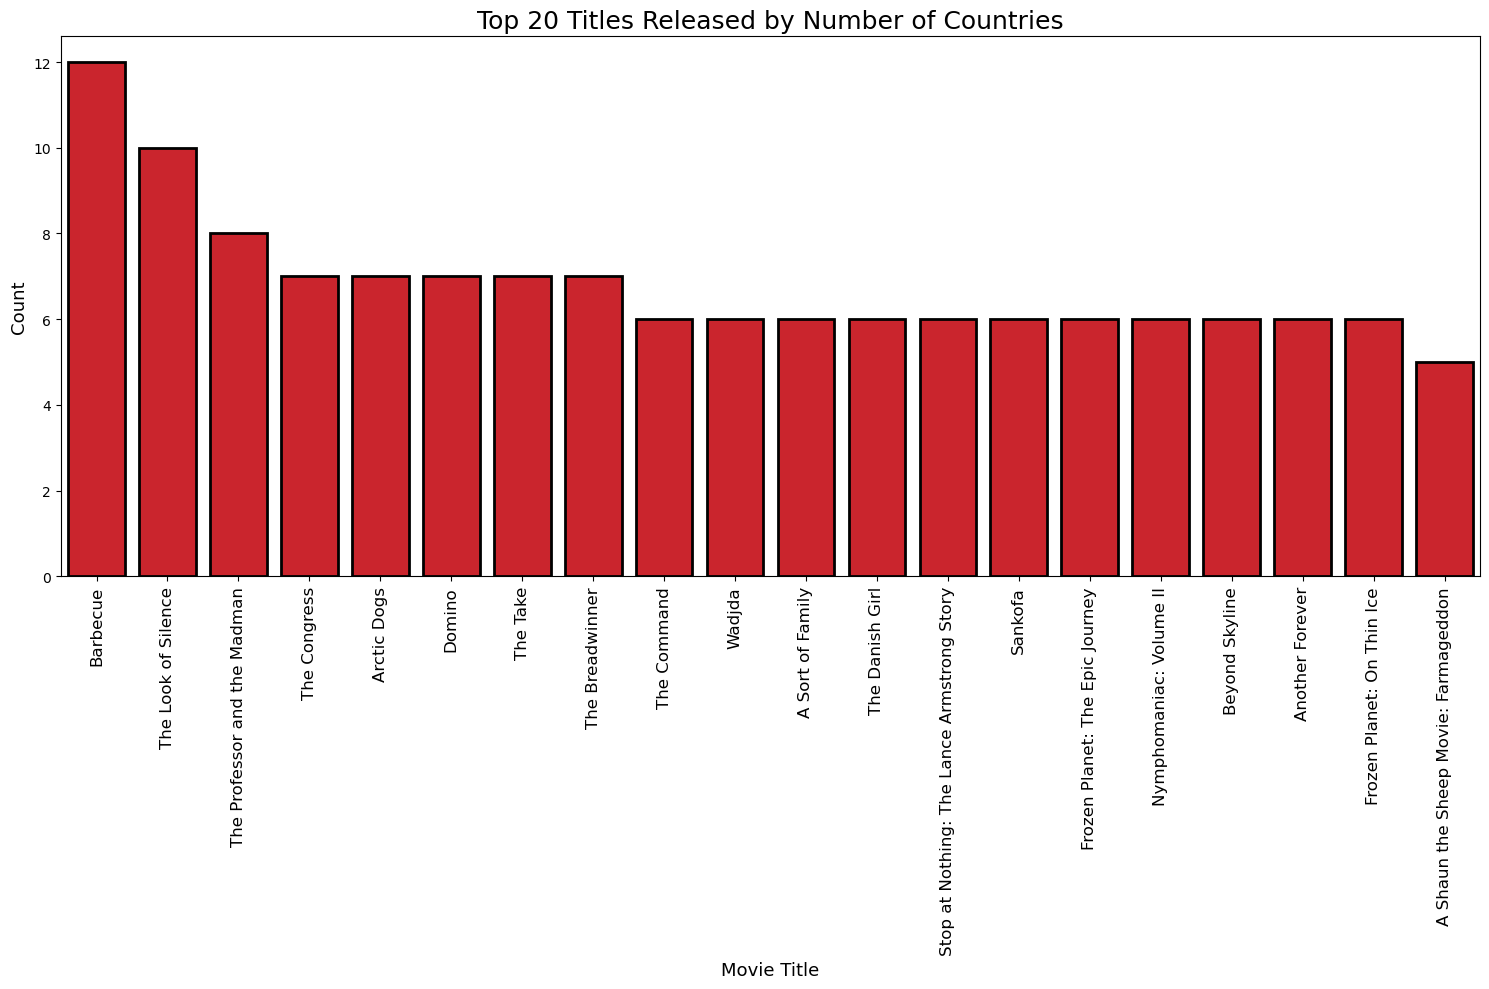

In [79]:
# Plotting the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(x='title', y='count', data=top_mtitles_country, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Movie Title', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Top 20 Titles Released by Number of Countries', fontsize=18)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

**Insight:**
- A total of 19 movies were produced in more than 5 countries.
- Barbecue was released in 12 countries, which is the highest for any movie.

## Barplot (Multi Country TV Show Releases)

In [80]:
merged_country = og_df.merge(country_df, on='show_id', how='inner')
merged_country = merged_country.loc[merged_country['type'] == 'TV Show', ['title', 'country']]
merged_country.head()

,title,country
1,Blood & Water,South Africa
2,Ganglands,Unknown Country
3,Jailbirds New Orleans,Unknown Country
4,Kota Factory,India
5,Midnight Mass,Unknown Country


In [81]:
top_ttitles_country = merged_country.groupby('title').aggregate(count = ('country', 'count')).sort_values(by='count', ascending=False).reset_index()
top_ttitles_country = top_ttitles_country.head(20)

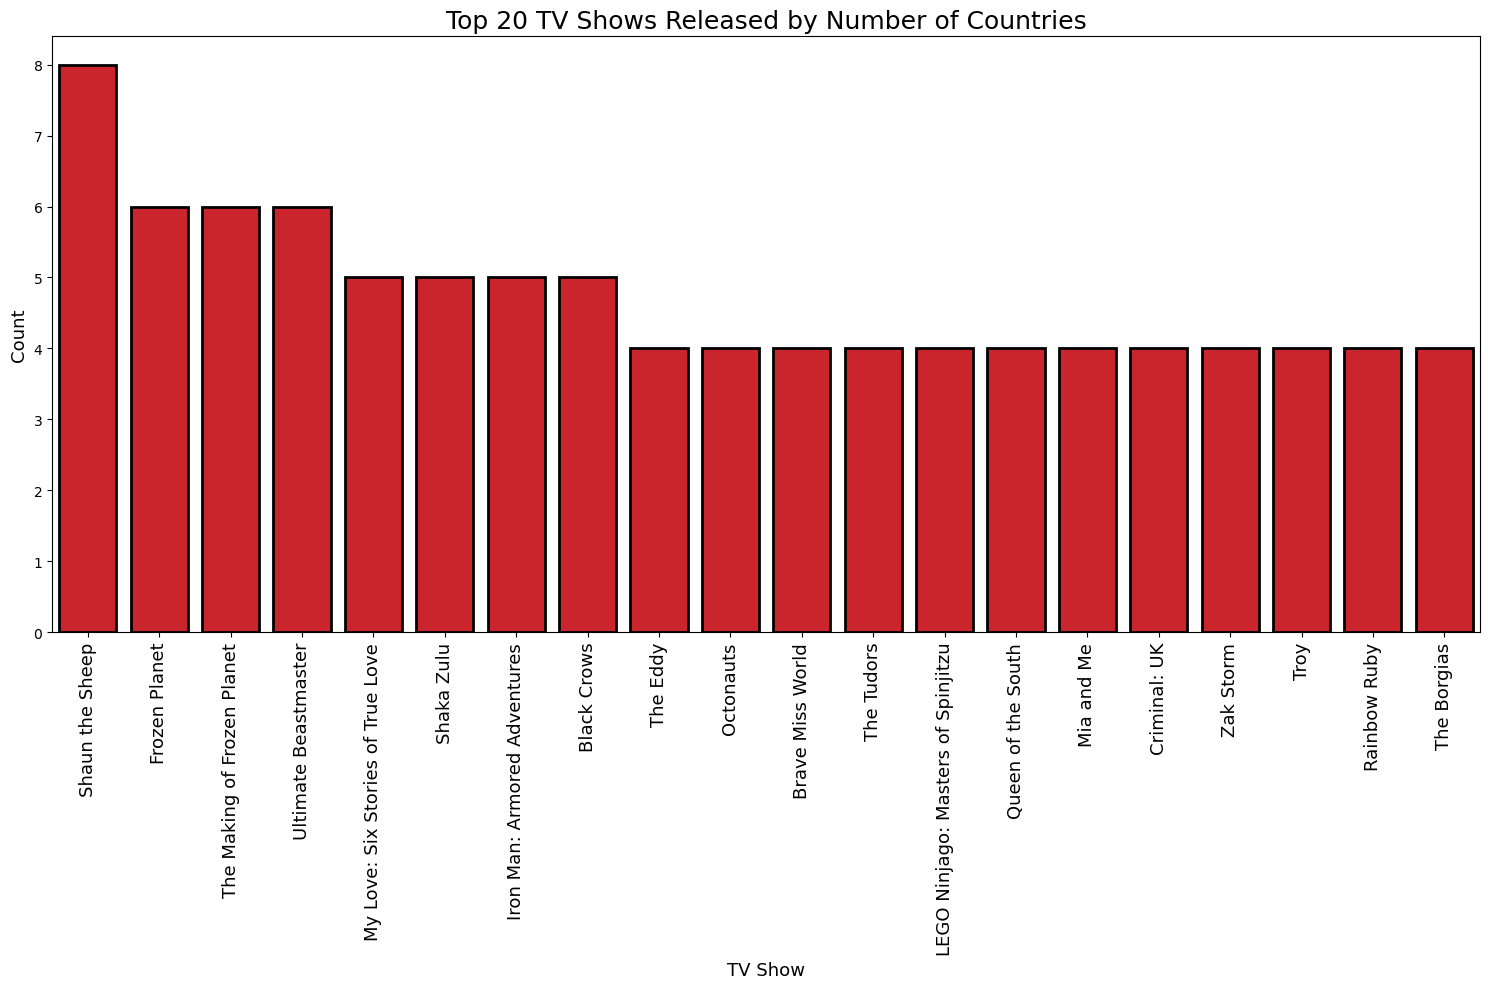

In [82]:
# Plotting the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(x='title', y='count', data=top_ttitles_country, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('TV Show', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Top 20 TV Shows Released by Number of Countries', fontsize=18)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.show()

**Insight:**
- 8 TV Shows were released in 5 or more countries.
- **Shaun The Sheep** was released in 8 countries, which is highest forany TV Shows in our dataset.

## Barplot (Top 10 Countries with Most Movies Titles)

In [83]:
merged_country = og_df.merge(country_df, on='show_id', how='inner')
merged_country = merged_country.loc[(merged_country['type'] == 'Movie') & (merged_country['country'] != 'Unknown Country'), ['show_id', 'country']]
merged_country.head()

,show_id,country
0,s1,United States
7,s8,United States
8,s8,Ghana
9,s8,Burkina Faso
10,s8,United Kingdom


In [84]:
top_country = merged_country.groupby('country').aggregate(count = ('show_id', 'count')).sort_values(by='count', ascending=False).reset_index()
top_country = top_country.head(10)
top_country

,country,count
0,United States,2752
1,India,962
2,United Kingdom,534
3,Canada,319
4,France,303
5,Germany,182
6,Spain,171
7,Japan,119
8,China,114
9,Mexico,111


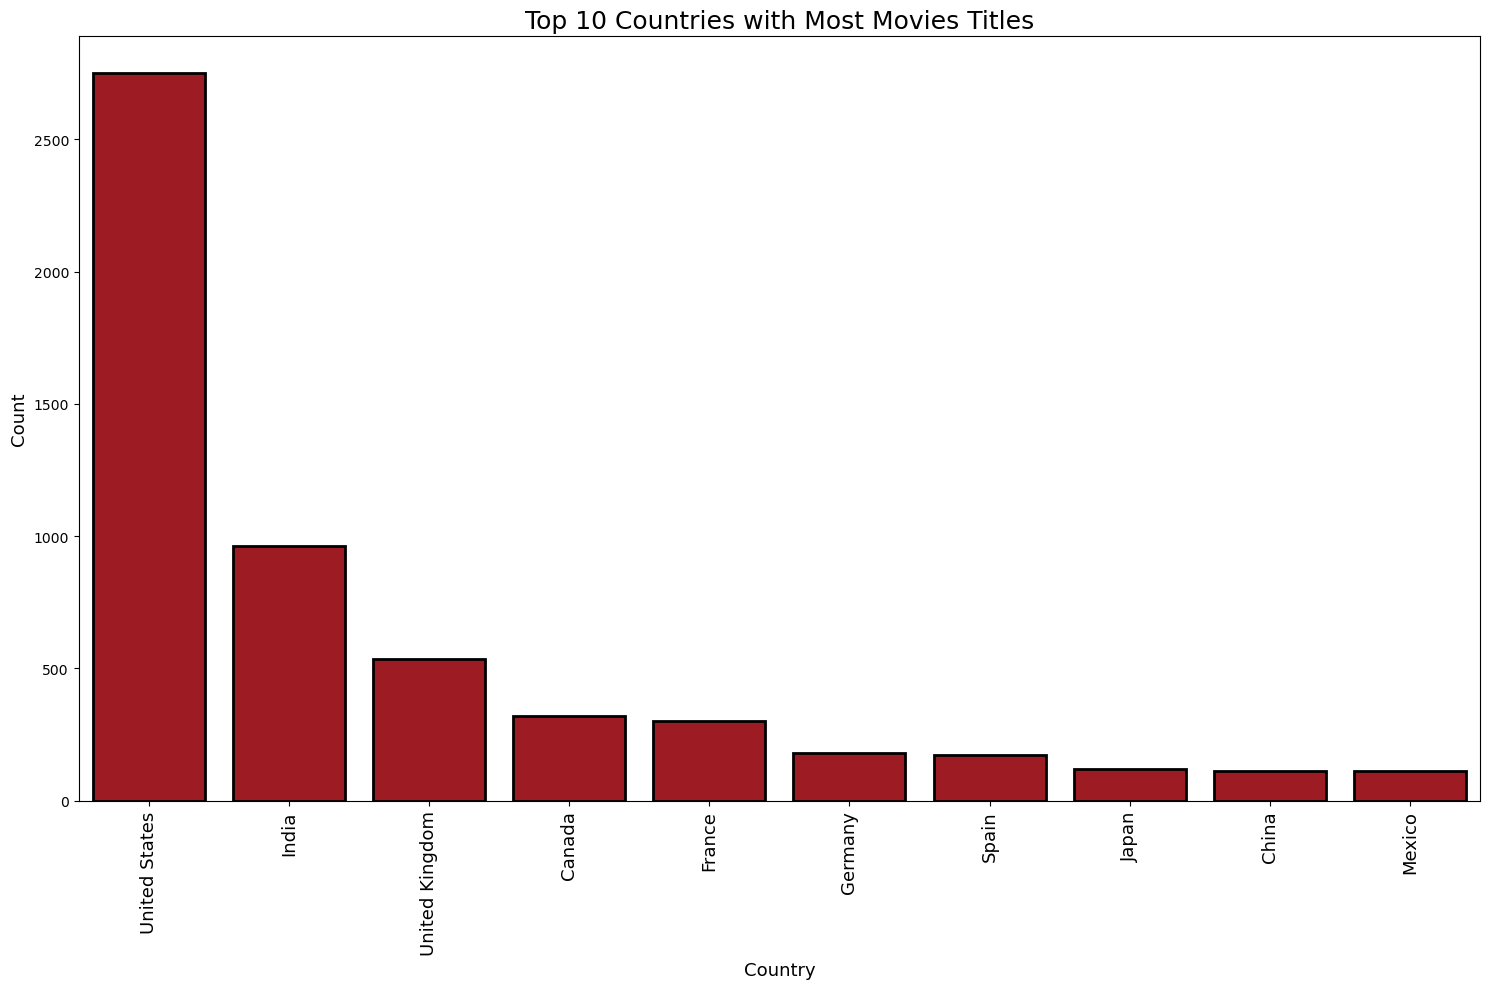

In [85]:
# Plotting the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(x='country', y='count', data=top_country, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Country', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Top 10 Countries with Most Movies Titles', fontsize=18)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.show()

**Insight:**
- The number of movies released in United States is significantly higher than any other country in our dataset.
- It is interesting to see that only Netflix has released more than 500 movies in only 3 countries.

**Recommendation:**
Netflix can look to release more movies in countries other than US, India, and UK

## Barplot (Top 10 Countries with Most TV Shows)

In [86]:
merged_country = og_df.merge(country_df, on='show_id', how='inner')
merged_country = merged_country.loc[(merged_country['type'] == 'TV Show') & (merged_country['country'] != 'Unknown Country'), ['show_id', 'country']]
merged_country.head()

,show_id,country
1,s2,South Africa
4,s5,India
13,s9,United Kingdom
21,s16,United States
23,s18,Mexico


In [87]:
top_country = merged_country.groupby('country').aggregate(count = ('show_id', 'count')).sort_values(by='count', ascending=False).reset_index()
top_country = top_country.head(10)
top_country

,country,count
0,United States,938
1,United Kingdom,272
2,Japan,199
3,South Korea,170
4,Canada,126
5,France,90
6,India,84
7,Taiwan,70
8,Australia,66
9,Spain,61


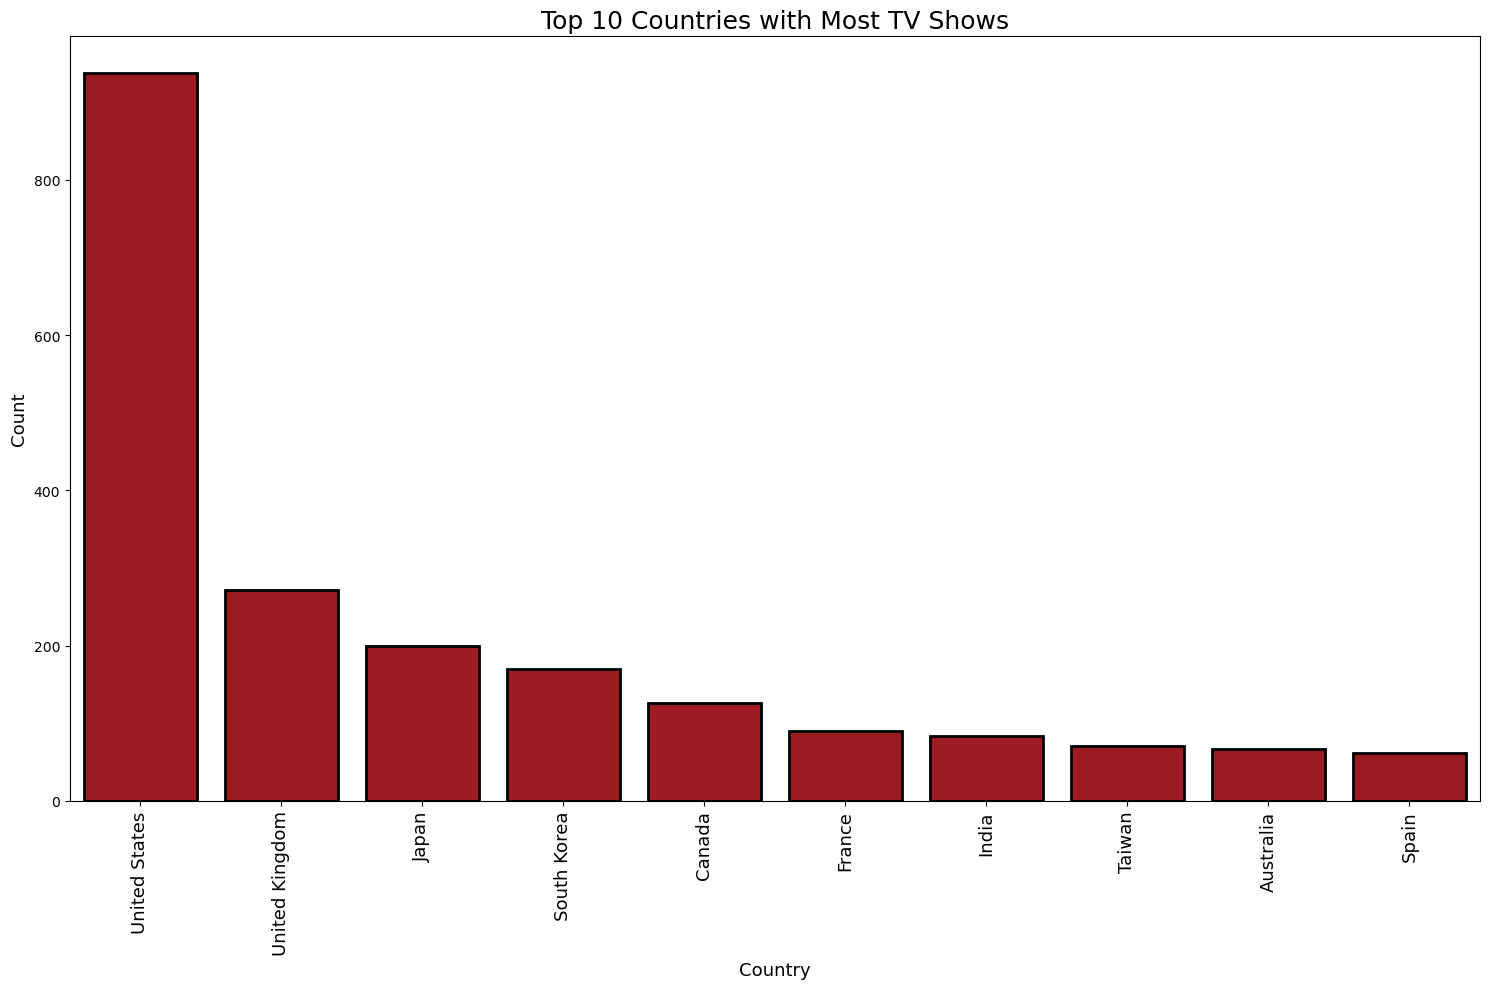

In [88]:
# Plotting the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(x='country', y='count', data=top_country, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Country', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Top 10 Countries with Most TV Shows', fontsize=18)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.show()

**Insight:** 
- Just like for movies, United States has a significantly high number of TV shows as compared to other countries.
- Interestingly only 3 countries have 200 or more TV shows.

**Recommendation:** Netflix can focus on releasing more TV shows in countries other than US

# Boxplot and Outlier Checks

## Distribution of Movie Durations by Decade 

In [89]:
movie_duration.head()

,show_id,type,title,date_added,release_year,rating,duration,description
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90,"As her father nears the end of his life, filmm..."
6,s7,Movie,My Little Pony: A New Generation,24-09-2021,2021,PG,91,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s..."
9,s10,Movie,The Starling,24-09-2021,2021,PG-13,104,A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,23-09-2021,2021,TV-MA,127,After most of her family is murdered in a terr...


In [90]:
movie_duration['release_year'].describe()

count    6131.000000
mean     2013.121514
std         9.678169
min      1942.000000
25%      2012.000000
50%      2016.000000
75%      2018.000000
max      2021.000000
Name: release_year, dtype: float64

In [91]:
years = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
decade = ['1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

movie_duration['decade'] = pd.cut(movie_duration['release_year'], bins=years, labels=decade)
movie_duration.head()

,show_id,type,title,date_added,release_year,rating,duration,description,decade
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s
6,s7,Movie,My Little Pony: A New Generation,24-09-2021,2021,PG,91,Equestria's divided. But a bright-eyed hero be...,2020s
7,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
9,s10,Movie,The Starling,24-09-2021,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s
12,s13,Movie,Je Suis Karl,23-09-2021,2021,TV-MA,127,After most of her family is murdered in a terr...,2020s


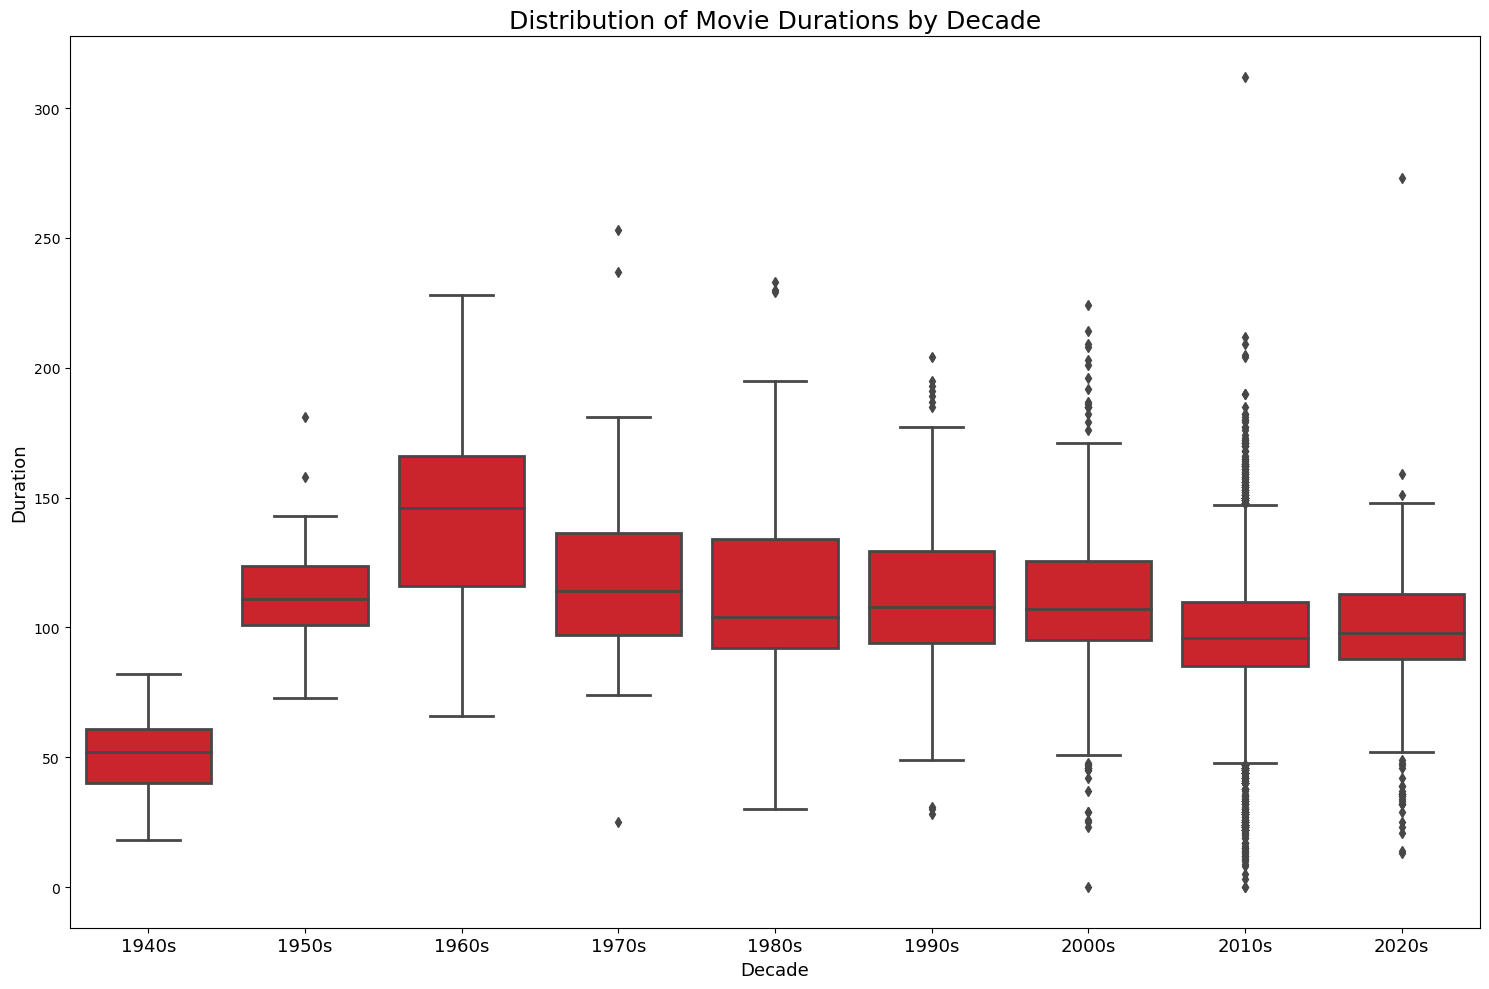

In [92]:
# Plotting the box plot
plt.figure(figsize=(15, 10))
sns.boxplot(x='decade', y='duration', data=movie_duration, color=netflix[0], linewidth=2)
plt.xlabel('Decade', fontsize=13)
plt.ylabel('Duration', fontsize=13)
plt.title('Distribution of Movie Durations by Decade', fontsize=18)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

**Insights:**
- Median duration of movies in 1950s became more than the maximum duration in 1940s. 
- Median duration of movies was highest in 1960s but seems to have gone down slightly since 1980s onwards.
- Median duration was almost constant between years 1980s and 2000s.

**Outlier Detection:**
- Decades 2000s, 2010s, 2020s had the most number of outliers as compared to prior decades.
- The max duration of movies was more than 300 mins in 2010s which is exceptionally higher than all the movies that are on Netflix's platform.
- Number of outliers have increased with each decades suggesting more experimentation with movie duration by directors.

## Distribution of TV Show Seasons by Decade

In [93]:
tv_show_duration.head()

,show_id,type,title,date_added,release_year,rating,duration,description
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2,"After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1,To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1,"Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2,In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,24-09-2021,2021,TV-MA,1,The arrival of a charismatic young priest brin...


In [94]:
tv_show_duration['release_year'].describe()

count    2676.000000
mean     2016.605755
std         5.740138
min      1925.000000
25%      2016.000000
50%      2018.000000
75%      2020.000000
max      2021.000000
Name: release_year, dtype: float64

In [95]:
years = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
decade = ['1920a', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

tv_show_duration['decade'] = pd.cut(tv_show_duration['release_year'], bins=years, labels=decade)
tv_show_duration.head()

,show_id,type,title,date_added,release_year,rating,duration,description,decade
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2,"After crossing paths at a party, a Cape Town t...",2020s
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1,To protect his family from a powerful drug lor...,2020s
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1,"Feuds, flirtations and toilet talk go down amo...",2020s
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2,In a city of coaching centers known to train I...,2020s
5,s6,TV Show,Midnight Mass,24-09-2021,2021,TV-MA,1,The arrival of a charismatic young priest brin...,2020s


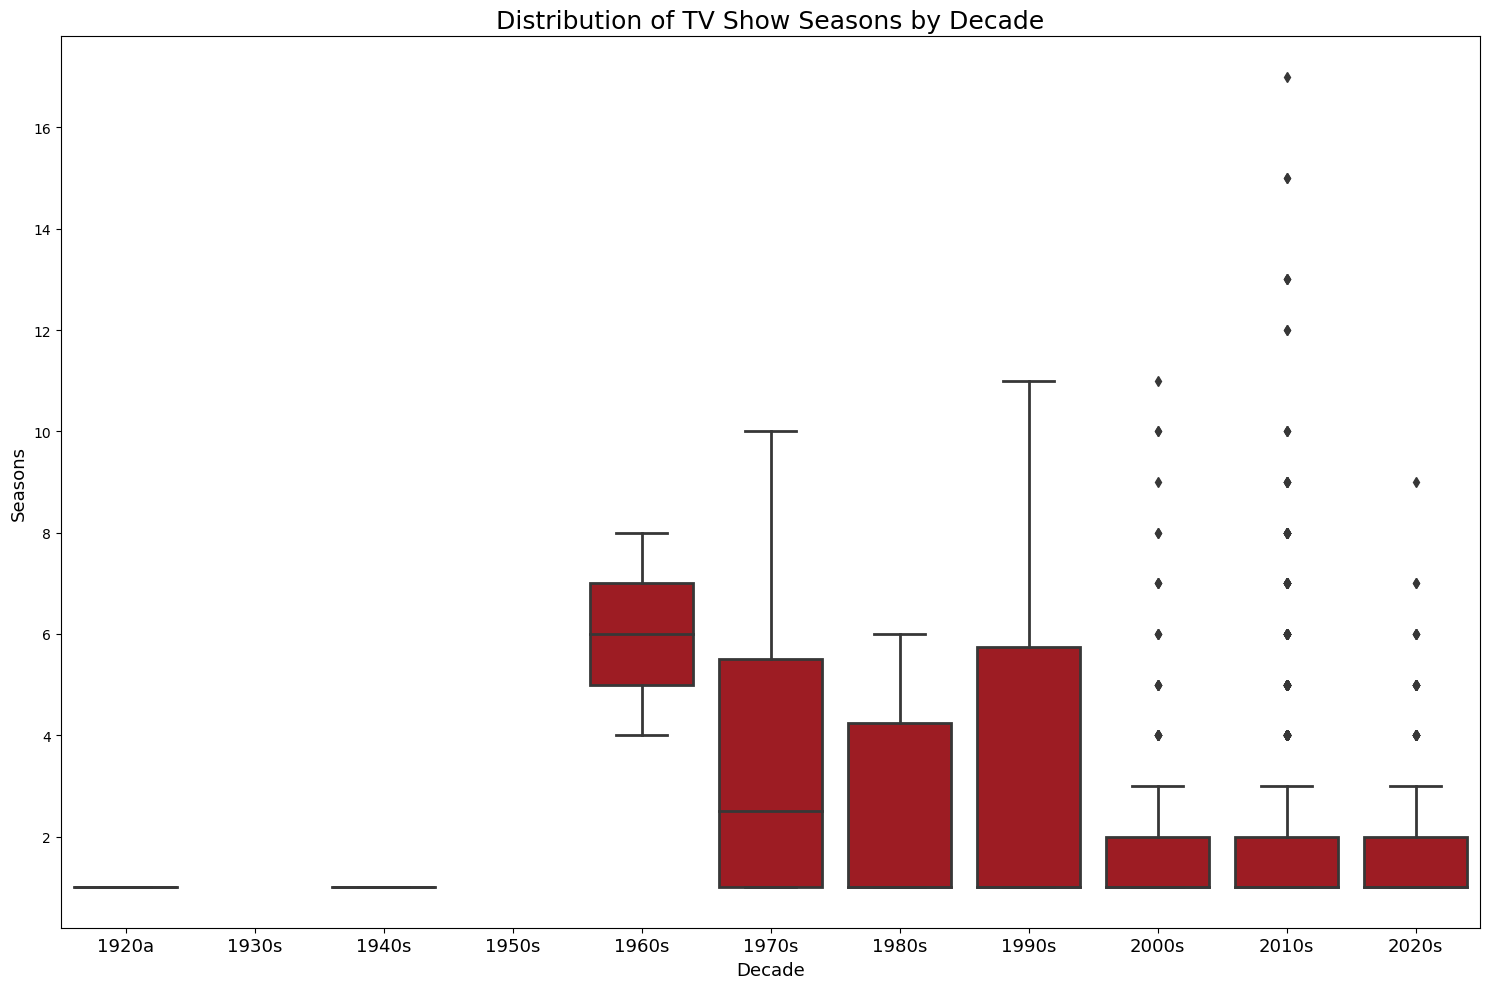

In [96]:
# Plotting the box plot
plt.figure(figsize=(15, 10))
sns.boxplot(x='decade', y='duration', data=tv_show_duration, color=netflix[1], linewidth=2)
plt.xlabel('Decade', fontsize=13)
plt.ylabel('Seasons', fontsize=13)
plt.title('Distribution of TV Show Seasons by Decade', fontsize=18)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

**Insights:**
- There are no TV shows on Netflix from 1930s and 1950s.  
- From 2000 onwards although the median number of seasons in the TV show were 2 but still there were multiple TV shows having number of seasons between 4 to 17.
- In 1960s the median number of seasons for TV shows was highest which i.e. 6 which reduced to 3 in the next decade.
- Median seasons was constant after 1980s.

**Outlier Detection:**
- The boxplot does not exhibit any outliers on the minimum side.
- Outliers can be found 2000s onwards
- Decade of 2020s is having TV show with maximum numbers ofseasons i.e. 17.

## Distribution of Movie Durations by Decade for Top 5 Countries with Most Number of Movies

In [169]:
merged_country_movie = og_df.merge(country_df, on='show_id', how='inner')
merged_country_movie.head()

,show_id,type,title,date_added,release_year,rating,duration,description,country
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm...",United States
1,s2,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",South Africa
2,s3,TV Show,Ganglands,24-09-2021,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,Unknown Country
3,s4,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo...",Unknown Country
4,s5,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,India


In [170]:
merged_country_movie = merged_country_movie.loc[(merged_country_movie['type'] == 'Movie') & (merged_country_movie['country'] != 'Unknown Country')]
merged_country_movie.head()

,show_id,type,title,date_added,release_year,rating,duration,description,country
0,s1,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90 min,"As her father nears the end of his life, filmm...",United States
7,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125 min,"On a photo shoot in Ghana, an American model s...",United States
8,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125 min,"On a photo shoot in Ghana, an American model s...",Ghana
9,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125 min,"On a photo shoot in Ghana, an American model s...",Burkina Faso
10,s8,Movie,Sankofa,24-09-2021,1993,TV-MA,125 min,"On a photo shoot in Ghana, an American model s...",United Kingdom


In [171]:
top_country_movie = merged_country_movie.groupby('country').aggregate(count = ('show_id', 'count')).sort_values(by='count', ascending=False).reset_index()
top_country_movie = top_country_movie.head(5)
top_country_movie

,country,count
0,United States,2752
1,India,962
2,United Kingdom,534
3,Canada,319
4,France,303


In [172]:
# merging movies and countries dataframe
merged_df = country_df.merge(movie_duration, on='show_id', how='inner')
merged_df.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
0,s1,United States,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s
1,s7,Unknown Country,Movie,My Little Pony: A New Generation,24-09-2021,2021,PG,91,Equestria's divided. But a bright-eyed hero be...,2020s
2,s8,United States,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
3,s8,Ghana,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
4,s8,Burkina Faso,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s


In [173]:
# filtering movies for top 5 countries from movies_duration dataframe
top_country_mv = merged_df.loc[merged_df['country'].isin(top_country_movie['country'])]
top_country_mv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
0,s1,United States,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s
2,s8,United States,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
5,s8,United Kingdom,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
8,s10,United States,Movie,The Starling,24-09-2021,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s
16,s25,India,Movie,Jeans,21-09-2021,1998,TV-14,166,When the father of the man she loves insists t...,1990s


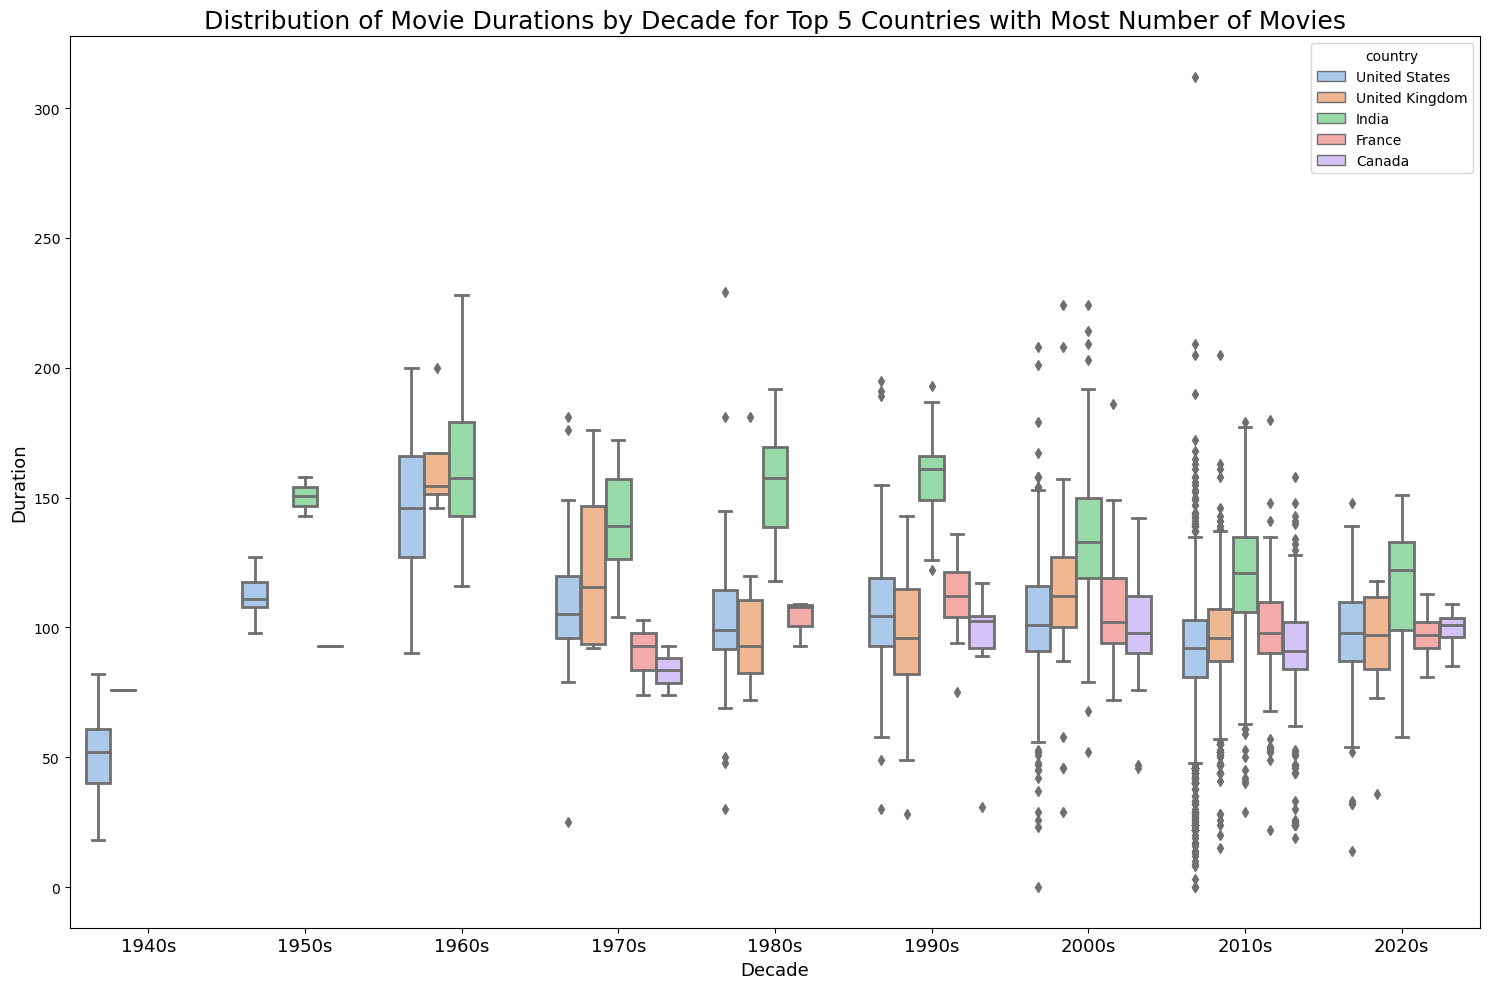

In [174]:
# Plotting the box plot
plt.figure(figsize=(15, 10))
sns.boxplot(x='decade', y='duration', hue='country', data=top_country_mv, linewidth=2, palette='pastel')
plt.xlabel('Decade', fontsize=13)
plt.ylabel('Duration', fontsize=13)
plt.title('Distribution of Movie Durations by Decade for Top 5 Countries with Most Number of Movies', fontsize=18)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

**Insights:**
- The oldest movies available on the Netflix platform dates to the 1940s and originates from the United States and some of them from United Kingdom.  
- Netflix offers movies from United Kingdom and India which were released in 1960s.
- Canadian Netflix content includes movies from the 1990s, making them the oldest from Canada.
- The median duration of Indian movies on Netflix has been gradually decreasing since the 1990s.
- French movie durations on Netflix experienced an increase from the 1970s to the 1990s, followed by a decline from that decade onwards.
- For movies from the United States, the median duration remained relatively stable from the 1970s to the 2000s, with a slight decline thereafter. 
- Canadian movie duration have remained nearly constant since the 1990s.

**Outlier Detection:**
- The most number of outliers for all countries was between 1990s till 2010s for all countries.
- United States seems to have most number of outliers in 2000s.

## Distribution of TV Show Seasons by Decade for Top 5 Countries with Most Number of TV Shows

In [175]:
merged_country_tv = country_df.merge(tv_show_duration, on='show_id', how='inner')
merged_country_tv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
0,s2,South Africa,TV Show,Blood & Water,24-09-2021,2021,TV-MA,2,"After crossing paths at a party, a Cape Town t...",2020s
1,s3,Unknown Country,TV Show,Ganglands,24-09-2021,2021,TV-MA,1,To protect his family from a powerful drug lor...,2020s
2,s4,Unknown Country,TV Show,Jailbirds New Orleans,24-09-2021,2021,TV-MA,1,"Feuds, flirtations and toilet talk go down amo...",2020s
3,s5,India,TV Show,Kota Factory,24-09-2021,2021,TV-MA,2,In a city of coaching centers known to train I...,2020s
4,s6,Unknown Country,TV Show,Midnight Mass,24-09-2021,2021,TV-MA,1,The arrival of a charismatic young priest brin...,2020s


In [231]:
merged_country_tv  = merged_country_tv.loc[merged_country_tv ['country'] != 'Unknown Country']
top_country_tv = merged_country_tv.groupby('country').aggregate(count = ('show_id', 'count')).sort_values(by='count', ascending=False).reset_index()
top_country_tv = top_country_tv.head(5)
top_country_tv

,country,count
0,United States,938
1,United Kingdom,272
2,Japan,199
3,South Korea,170
4,Canada,126


In [232]:
# filtering TV Shows for top 5 countries from merged_country_tv dataframe
top_country_tvs = merged_country_tv.loc[merged_country_tv['country'].isin(top_country_tv['country'])]
top_country_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
5,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s
9,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s
16,s33,United Kingdom,TV Show,Sex Education,17-09-2021,2020,TV-MA,3,Insecure Otis has all the answers when it come...,2010s
21,s41,United States,TV Show,He-Man and the Masters of the Universe,16-09-2021,2021,TV-Y7,1,Mighty teen Adam and his heroic squad of misfi...,2020s
25,s56,United States,TV Show,Nailed It,15-09-2021,2021,TV-PG,6,Home bakers with a terrible track record take ...,2020s


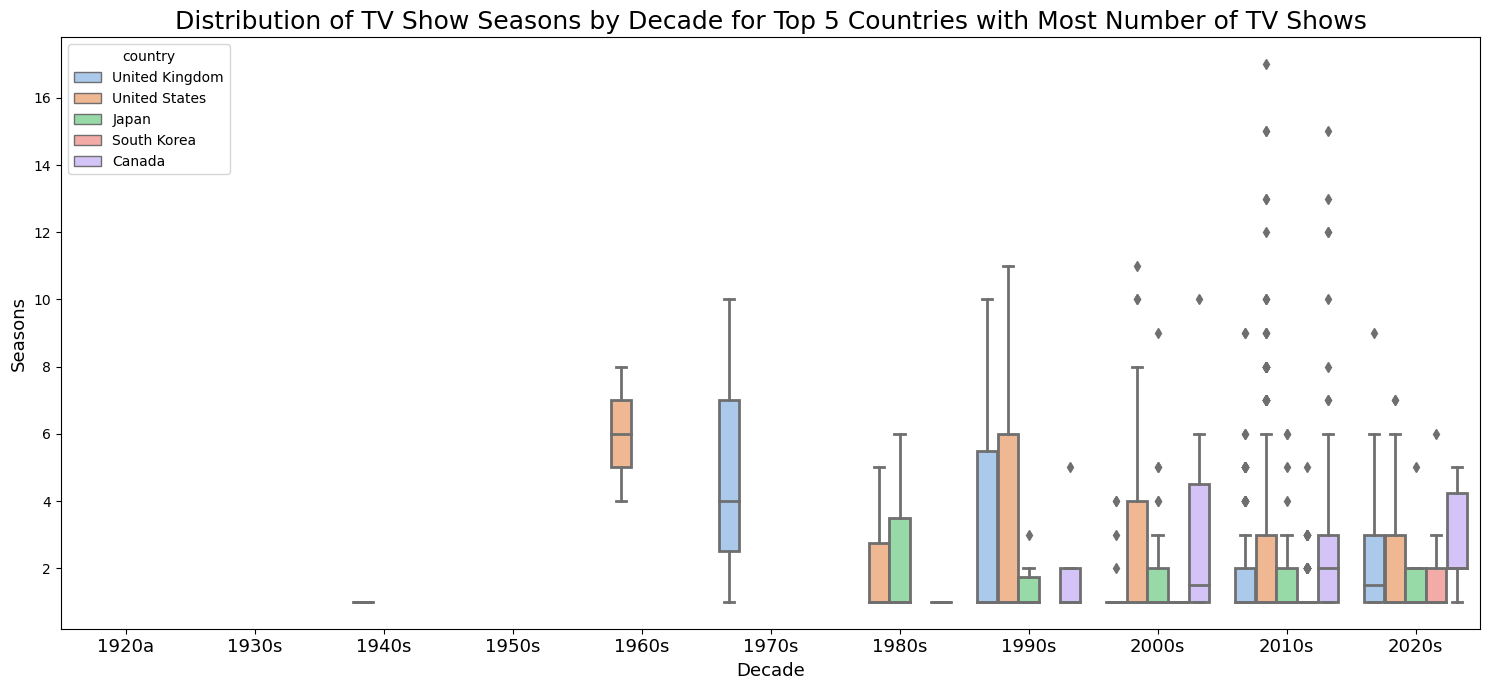

In [233]:
# Plotting the box plot
plt.figure(figsize=(15, 7))
sns.boxplot(x='decade', y='duration', hue='country', data=top_country_tvs, linewidth=2, palette='pastel')
plt.xlabel('Decade', fontsize=13)
plt.ylabel('Seasons', fontsize=13)
plt.title('Distribution of TV Show Seasons by Decade for Top 5 Countries with Most Number of TV Shows', fontsize=18)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

**Insights:** 
- Median number of seasons for TV show have fallen down from 1970s onward
- The number of TV Shows from Canada has increased since 2000s while the number of TV shows from United States has reduced a lot.

**Outlier Detection:**
- No outliers are observed on the minimum side of the box plot.
- Outliers have significantly increased since 2000s.
- United States has shown a significant increase in outliers since 2010s.

# Heatmaps 

## Appropriate Month to Launch Movie in Top 5 Countries

In [179]:
top_country_mv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
0,s1,United States,Movie,Dick Johnson Is Dead,25-09-2021,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s
2,s8,United States,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
5,s8,United Kingdom,Movie,Sankofa,24-09-2021,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s
8,s10,United States,Movie,The Starling,24-09-2021,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s
16,s25,India,Movie,Jeans,21-09-2021,1998,TV-14,166,When the father of the man she loves insists t...,1990s


In [180]:
# extracting month from date_added
top_country_mv['date_added'] = pd.to_datetime(top_country_mv['date_added'], format='%d-%m-%Y')
top_country_mv['month_added'] = top_country_mv['date_added'].apply(lambda x: x.strftime('%B'))
top_country_mv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September
2,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September
5,s8,United Kingdom,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September
8,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September
16,s25,India,Movie,Jeans,2021-09-21,1998,TV-14,166,When the father of the man she loves insists t...,1990s,September


In [181]:
# extracting year from date_added
top_country_mv['date_added'] = pd.to_datetime(top_country_mv['date_added'], format='%d-%m-%Y')
top_country_mv['year_added'] = top_country_mv['date_added'].dt.year
top_country_mv.tail()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added
7812,s8800,India,Movie,Zenda,2018-02-15,2009,TV-14,120,A change in the leadership of a political part...,2000s,February,2018
7815,s8803,United States,Movie,Zodiac,2019-11-20,2007,R,158,"A political cartoonist, a crime reporter and a...",2000s,November,2019
7816,s8805,United States,Movie,Zombieland,2019-01-11,2009,R,88,Looking to survive in a world taken over by zo...,2000s,January,2019
7817,s8806,United States,Movie,Zoom,2020-11-01,2006,PG,88,"Dragged from civilian life, a former superhero...",2000s,November,2020
7818,s8807,India,Movie,Zubaan,2019-02-03,2015,TV-14,111,A scrappy but poor boy worms his way into a ty...,2010s,February,2019


In [182]:
year_month_count = top_country_mv.groupby(['year_added', 'month_added']).aggregate(count = ('show_id', 'count')).reset_index()
year_month_count.head()

,year_added,month_added,count
0,2008,January,1
1,2009,November,1
2,2010,January,1
3,2011,January,11
4,2011,May,1


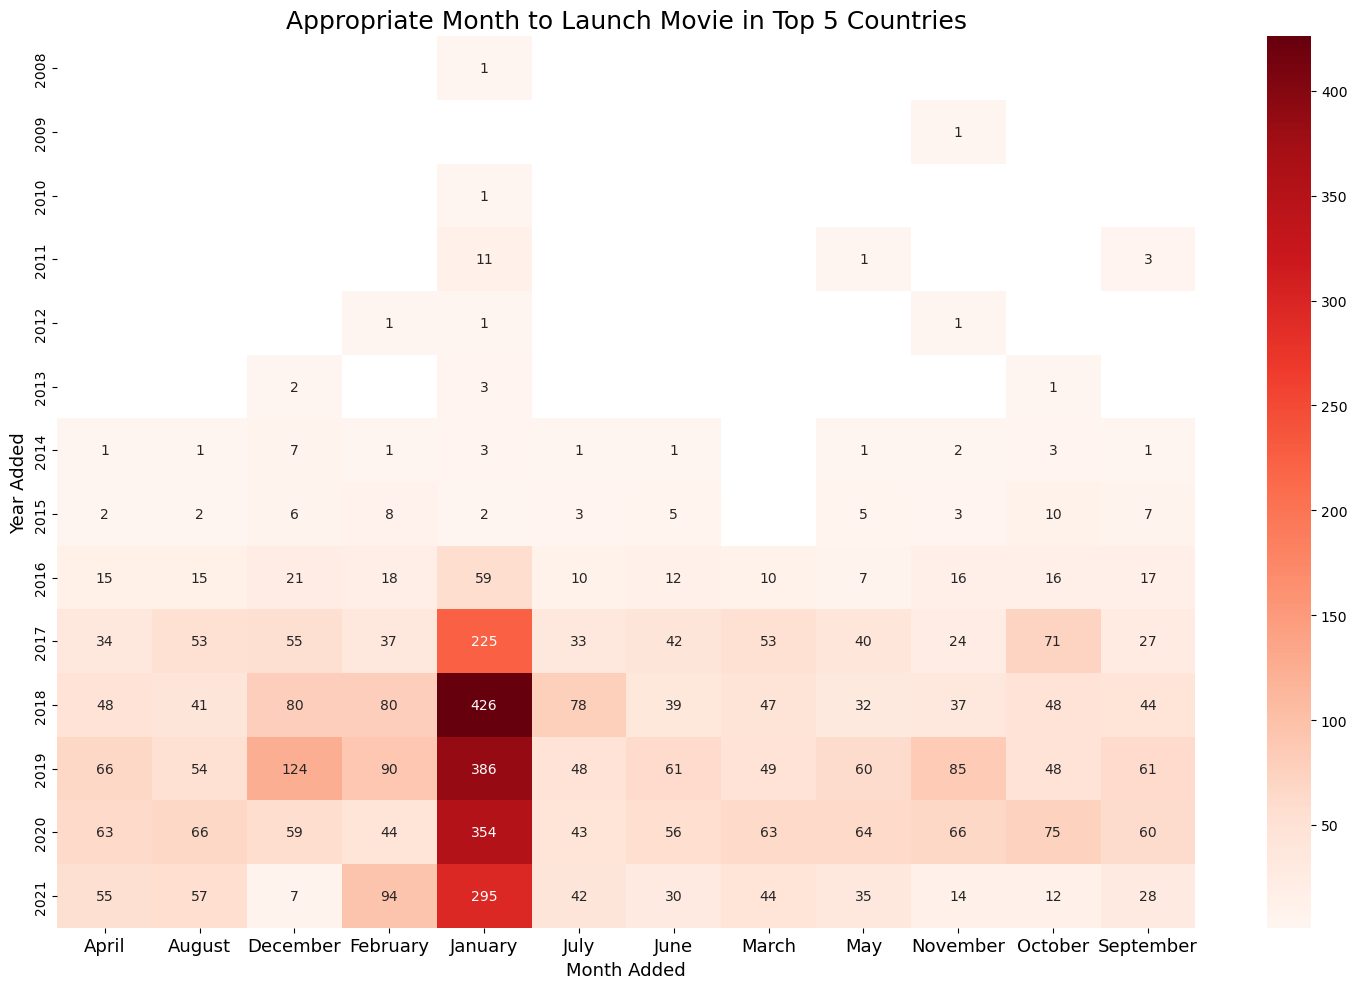

In [183]:
# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data=year_month_count.pivot_table(index='year_added', columns='month_added', values='count'),
            cmap='Reds', annot=True, fmt='g', cbar=True)
plt.xlabel('Month Added', fontsize=13)
plt.ylabel('Year Added', fontsize=13)
plt.title('Appropriate Month to Launch Movie in Top 5 Countries', fontsize=18)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

**Insight:** January seems to be the month with most number of movie releases.

## Appropriate Month to Launch TV Show in Top 5 Countries

In [184]:
top_country_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
5,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s
9,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s
16,s33,United Kingdom,TV Show,Sex Education,17-09-2021,2020,TV-MA,3,Insecure Otis has all the answers when it come...,2010s
21,s41,United States,TV Show,He-Man and the Masters of the Universe,16-09-2021,2021,TV-Y7,1,Mighty teen Adam and his heroic squad of misfi...,2020s
25,s56,United States,TV Show,Nailed It,15-09-2021,2021,TV-PG,6,Home bakers with a terrible track record take ...,2020s


In [185]:
# extracting month from date_added
top_country_tvs = top_country_tvs.loc[top_country_tvs['date_added'].isna() == False]
top_country_tvs['date_added'] = pd.to_datetime(top_country_tvs['date_added'], format='%d-%m-%Y')
top_country_tvs['month_added'] = top_country_tvs['date_added'].apply(lambda x: x.strftime('%B'))
top_country_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added
5,s9,United Kingdom,TV Show,The Great British Baking Show,2021-09-24,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,September
9,s16,United States,TV Show,Dear White People,2021-09-22,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,September
16,s33,United Kingdom,TV Show,Sex Education,2021-09-17,2020,TV-MA,3,Insecure Otis has all the answers when it come...,2010s,September
21,s41,United States,TV Show,He-Man and the Masters of the Universe,2021-09-16,2021,TV-Y7,1,Mighty teen Adam and his heroic squad of misfi...,2020s,September
25,s56,United States,TV Show,Nailed It,2021-09-15,2021,TV-PG,6,Home bakers with a terrible track record take ...,2020s,September


In [186]:
# extracting year from date_added
top_country_tvs['date_added'] = pd.to_datetime(top_country_tvs['date_added'], format='%d-%m-%Y')
top_country_tvs['year_added'] = top_country_tvs['date_added'].dt.year
top_country_tvs.tail()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added
3019,s8781,United States,TV Show,Yo-Kai Watch,2016-01-04,2015,TV-Y7,1,Nate frees a mythical being trapped in a magic...,2010s,January,2016
3022,s8796,Japan,TV Show,Yu-Gi-Oh! Arc-V,2018-01-05,2015,TV-Y7,2,Now that he's discovered the Pendulum Summonin...,2010s,January,2018
3023,s8796,Canada,TV Show,Yu-Gi-Oh! Arc-V,2018-01-05,2015,TV-Y7,2,Now that he's discovered the Pendulum Summonin...,2010s,January,2018
3025,s8798,United States,TV Show,Zak Storm,2018-09-13,2016,TV-Y7,3,Teen surfer Zak Storm is mysteriously transpor...,2010s,September,2018
3027,s8798,South Korea,TV Show,Zak Storm,2018-09-13,2016,TV-Y7,3,Teen surfer Zak Storm is mysteriously transpor...,2010s,September,2018


In [187]:
year_month_count_tv = top_country_tvs.groupby(['year_added', 'month_added']).aggregate(count = ('show_id', 'count')).reset_index()
year_month_count_tv.head()

,year_added,month_added,count
0,2008,April,1
1,2013,August,1
2,2013,February,1
3,2013,January,2
4,2013,March,1


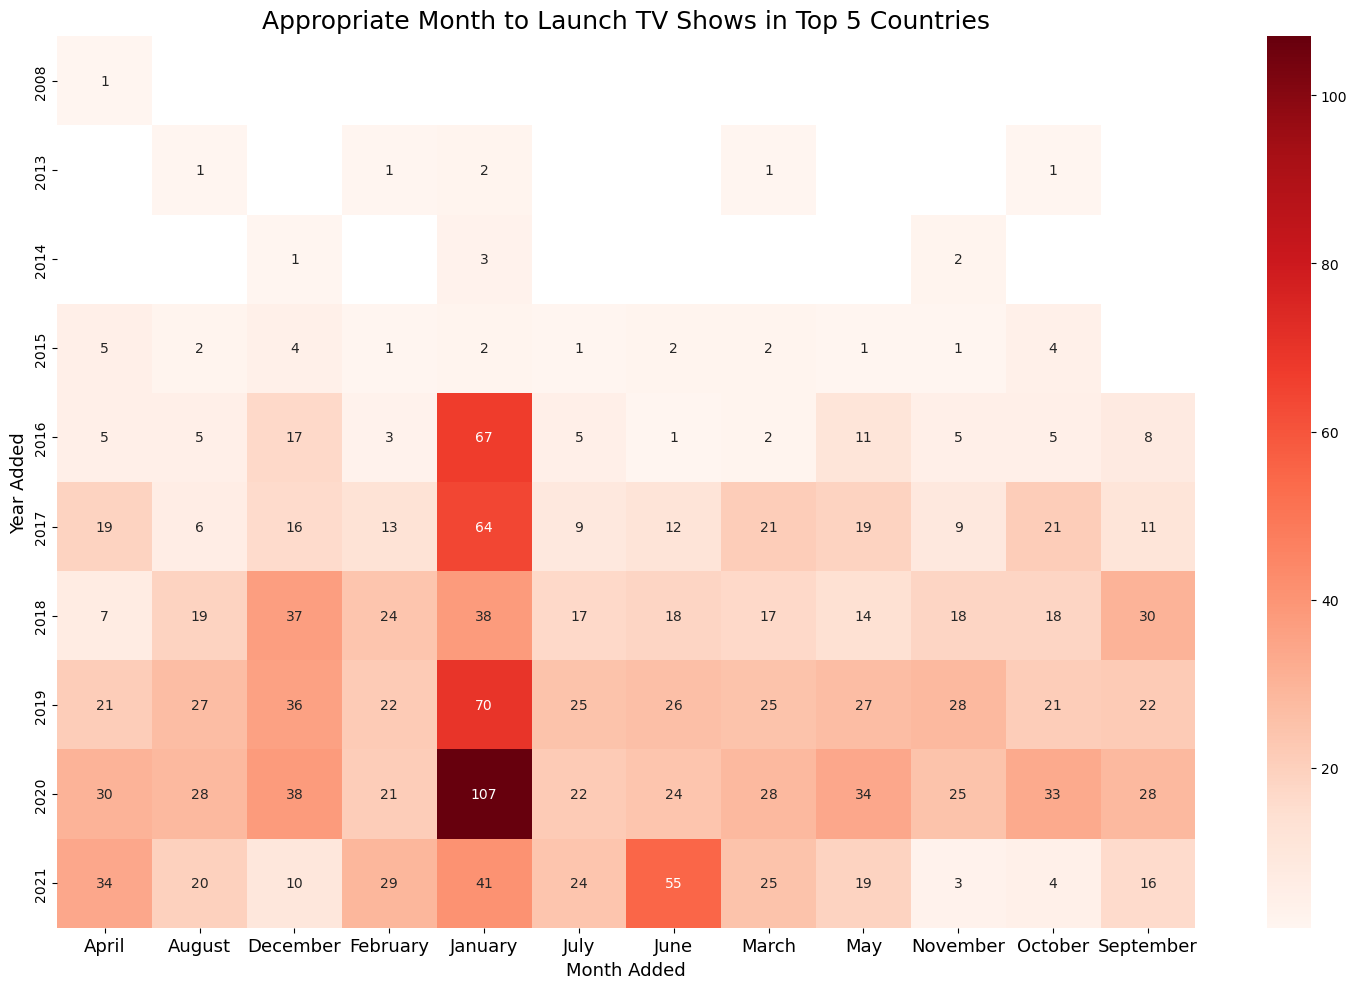

In [188]:
# Plotting the box plot
plt.figure(figsize=(15, 10))
sns.heatmap(data=year_month_count_tv.pivot_table(index='year_added', columns='month_added', values='count'),
            cmap='Reds', annot=True, fmt='g', cbar=True)
plt.xlabel('Month Added', fontsize=13)
plt.ylabel('Year Added', fontsize=13)
plt.title('Appropriate Month to Launch TV Shows in Top 5 Countries', fontsize=18)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

**Insight:** January seems to be the month with most number of TV Show releases.

## Top Actors and Directors For Movies In Top 5 Most Popular Countries

### Top 5 Movie Directors

In [189]:
top_country_mv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September,2021
2,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021
5,s8,United Kingdom,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021
8,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September,2021
16,s25,India,Movie,Jeans,2021-09-21,1998,TV-14,166,When the father of the man she loves insists t...,1990s,September,2021


In [190]:
dir_df.head()

,show_id,director
0,s1,Kirsten Johnson
1,s2,Unknown Director
2,s3,Julien Leclercq
3,s4,Unknown Director
4,s5,Unknown Director


In [191]:
top_dir_movie = top_country_mv.merge(dir_df, on='show_id', how='inner')
top_dir_movie = top_dir_movie[top_dir_movie['director'] != 'Unknown Director']
top_dir_movie.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,director
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September,2021,Kirsten Johnson
1,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Haile Gerima
2,s8,United Kingdom,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Haile Gerima
3,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September,2021,Theodore Melfi
4,s25,India,Movie,Jeans,2021-09-21,1998,TV-14,166,When the father of the man she loves insists t...,1990s,September,2021,S. Shankar


In [192]:
# United States
top_dir_movie_us = top_dir_movie.loc[top_dir_movie['country'] == 'United States']
top_dir_movie_us.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,director
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September,2021,Kirsten Johnson
1,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Haile Gerima
3,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September,2021,Theodore Melfi
5,s28,United States,Movie,Grown Ups,2021-09-20,2010,PG-13,103,Mourning the loss of their beloved junior high...,2000s,September,2021,Dennis Dugan
6,s29,United States,Movie,Dark Skies,2021-09-19,2013,PG-13,97,A familyâ€™s idyllic suburban life shatters wh...,2010s,September,2021,Scott Stewart


In [193]:
top_dir_movie_us_count = top_dir_movie_us.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_movie_us_count.reset_index(inplace=True)
top_dir_movie_us_count = top_dir_movie_us_count.head()
top_dir_movie_us_count

,director,count
0,Jay Karas,15
1,Marcus Raboy,14
2,Jay Chapman,12
3,Martin Scorsese,12
4,Steven Spielberg,11


In [194]:
# United Kingdom
top_dir_movie_uk = top_dir_movie.loc[top_dir_movie['country'] == 'United Kingdom']
top_dir_movie_uk_count = top_dir_movie_uk.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_movie_uk_count.reset_index(inplace=True)
top_dir_movie_uk_count = top_dir_movie_uk_count.head()
top_dir_movie_uk_count

,director,count
0,Edward Cotterill,4
1,Vince Marcello,3
2,Orlando von Einsiedel,3
3,Jerry Rothwell,3
4,Blair Simmons,3


In [195]:
# India
top_dir_movie_in = top_dir_movie.loc[top_dir_movie['country'] == 'India']
top_dir_movie_in_count = top_dir_movie_in.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_movie_in_count.reset_index(inplace=True)
top_dir_movie_in_count = top_dir_movie_in_count.head()
top_dir_movie_in_count

,director,count
0,David Dhawan,9
1,Anurag Kashyap,8
2,Umesh Mehra,8
3,Dibakar Banerjee,7
4,Ram Gopal Varma,7


In [196]:
top_dir_movie[top_dir_movie['country'] == 'United States'].head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,director
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September,2021,Kirsten Johnson
1,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Haile Gerima
3,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September,2021,Theodore Melfi
5,s28,United States,Movie,Grown Ups,2021-09-20,2010,PG-13,103,Mourning the loss of their beloved junior high...,2000s,September,2021,Dennis Dugan
6,s29,United States,Movie,Dark Skies,2021-09-19,2013,PG-13,97,A familyâ€™s idyllic suburban life shatters wh...,2010s,September,2021,Scott Stewart


In [201]:
top_dir_movie_fr = top_dir_movie.loc[top_dir_movie['country'] == 'France']
top_dir_movie_fr.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,director
9,s30,France,Movie,Paranoia,2021-09-19,2013,PG-13,106,"Blackmailed by his company's CEO, a low-level ...",2010s,September,2021,Robert Luketic
20,s92,France,Movie,The Women and the Murderer,2021-09-09,2021,TV-14,92,This documentary traces the capture of serial ...,2020s,September,2021,Mona Achache
21,s92,France,Movie,The Women and the Murderer,2021-09-09,2021,TV-14,92,This documentary traces the capture of serial ...,2020s,September,2021,Patricia Tourancheau
31,s116,France,Movie,Bright Star,2021-02-09,2009,PG,119,This drama details the passionate three-year r...,2000s,February,2021,Jane Campion
37,s123,France,Movie,In the Cut,2021-02-09,2003,R,118,After embarking on an affair with the cop prob...,2000s,February,2021,Jane Campion


In [198]:
# France
top_dir_movie_fr = top_dir_movie.loc[top_dir_movie['country'] == 'France']
top_dir_movie_fr_count = top_dir_movie_fr.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_movie_fr_count.reset_index(inplace=True)
top_dir_movie_fr_count = top_dir_movie_fr_count.head()
top_dir_movie_fr_count

,director,count
0,Thierry Donard,5
1,Youssef Chahine,4
2,Olivier Assayas,3
3,Jane Campion,3
4,Florent Bodin,3


In [199]:
# Canada
top_cast_movie_cn = top_dir_movie.loc[top_dir_movie['country'] == 'Canada']
top_cast_movie_cn_count = top_cast_movie_cn.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_movie_cn_count.reset_index(inplace=True)
top_cast_movie_cn_count = top_cast_movie_cn_count.head()
top_cast_movie_cn_count

,director,count
0,Justin G. Dyck,8
1,Robert Vince,5
2,Mike Clattenburg,5
3,Barry Avrich,4
4,John Paul Tremblay,4


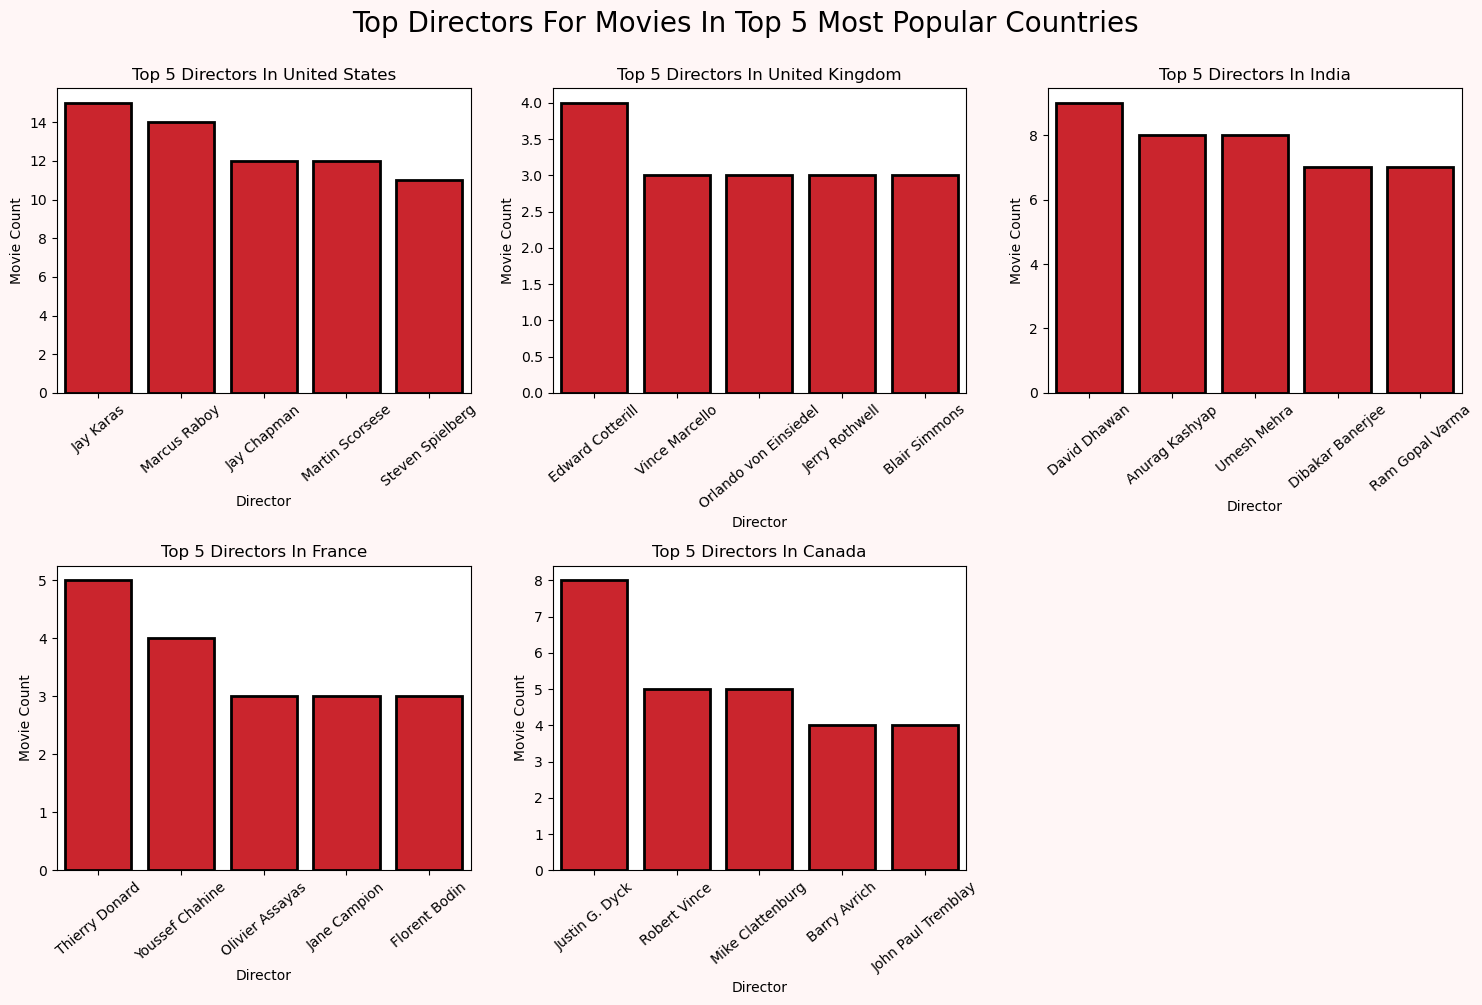

In [200]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United States
plt.subplot(2,3,1)
sns.barplot(x='director', y='count', data=top_dir_movie_us_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Directors In United States', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# United Kingdom
plt.subplot(2,3,2)
sns.barplot(x='director', y='count', data=top_dir_movie_uk_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Directors In United Kingdom', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# India
plt.subplot(2,3,3)
sns.barplot(x='director', y='count', data=top_dir_movie_in_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Directors In India', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# France
plt.subplot(2,3,4)
sns.barplot(x='director', y='count', data=top_dir_movie_fr_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Directors In France', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# Canada
plt.subplot(2,3,5)
sns.barplot(x='director', y='count', data=top_cast_movie_cn_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Directors In Canada', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

fig.suptitle('Top Directors For Movies In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insight:** Top 5 directors for the movie are identified for the top 5 countries. Details of the same will be available in the recommendations section.

### Top 5 Movie Actors

In [203]:
top_cast_movie = top_country_mv.merge(cast_df, on='show_id', how='inner')
top_cast_movie = top_cast_movie[top_cast_movie['cast'] != 'Unknown Actor']
top_cast_movie.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,cast
1,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Kofi Ghanaba
2,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Oyafunmike Ogunlano
3,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Alexandra Duah
4,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Nick Medley
5,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Mutabaruka


In [204]:
# United States
top_cast_movie_us = top_cast_movie.loc[top_cast_movie['country'] == 'United States']
top_cast_movie_us.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,cast
1,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Kofi Ghanaba
2,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Oyafunmike Ogunlano
3,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Alexandra Duah
4,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Nick Medley
5,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021,Mutabaruka


In [206]:
top_cast_movie_us_count = top_cast_movie_us.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_movie_us_count.reset_index(inplace=True)
top_cast_movie_us_count = top_cast_movie_us_count.head()
top_cast_movie_us_count

,cast,count
0,Samuel L. Jackson,21
1,Adam Sandler,20
2,James Franco,19
3,Nicolas Cage,18
4,Morgan Freeman,15


In [209]:
# United Kingdom
top_cast_movie_uk = top_cast_movie.loc[top_cast_movie['country'] == 'United Kingdom']
top_cast_movie_uk_count = top_cast_movie_uk.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_movie_uk_count.reset_index(inplace=True)
top_cast_movie_uk_count = top_cast_movie_uk_count.head()
top_cast_movie_uk_count

,cast,count
0,John Cleese,11
1,Michael Palin,9
2,Judi Dench,9
3,Brendan Gleeson,8
4,Helena Bonham Carter,8


In [210]:
# India
top_cast_movie_in = top_cast_movie.loc[top_cast_movie['country'] == 'India']
top_cast_movie_in_count = top_cast_movie_in.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_movie_in_count.reset_index(inplace=True)
top_cast_movie_in_count = top_cast_movie_in_count.head()
top_cast_movie_in_count

,cast,count
0,Anupam Kher,40
1,Shah Rukh Khan,34
2,Naseeruddin Shah,31
3,Om Puri,29
4,Akshay Kumar,29


In [211]:
# France
top_cast_movie_fr = top_cast_movie.loc[top_cast_movie['country'] == 'France']
top_cast_movie_fr_count = top_cast_movie_fr.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_movie_fr_count.reset_index(inplace=True)
top_cast_movie_fr_count = top_cast_movie_fr_count.head()
top_cast_movie_fr_count

,cast,count
0,Wille Lindberg,5
1,Brendan Gleeson,4
2,Kristin Scott Thomas,4
3,LÃ©a Seydoux,4
4,Matt Annetts,4


In [212]:
# Canada
top_cast_movie_cn = top_cast_movie.loc[top_cast_movie['country'] == 'Canada']
top_cast_movie_cn_count = top_cast_movie_cn.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_movie_cn_count.reset_index(inplace=True)
top_cast_movie_cn_count = top_cast_movie_cn_count.head()
top_cast_movie_cn_count

,cast,count
0,Robb Wells,10
1,John Paul Tremblay,10
2,John Dunsworth,9
3,Michela Luci,7
4,Mike Smith,7


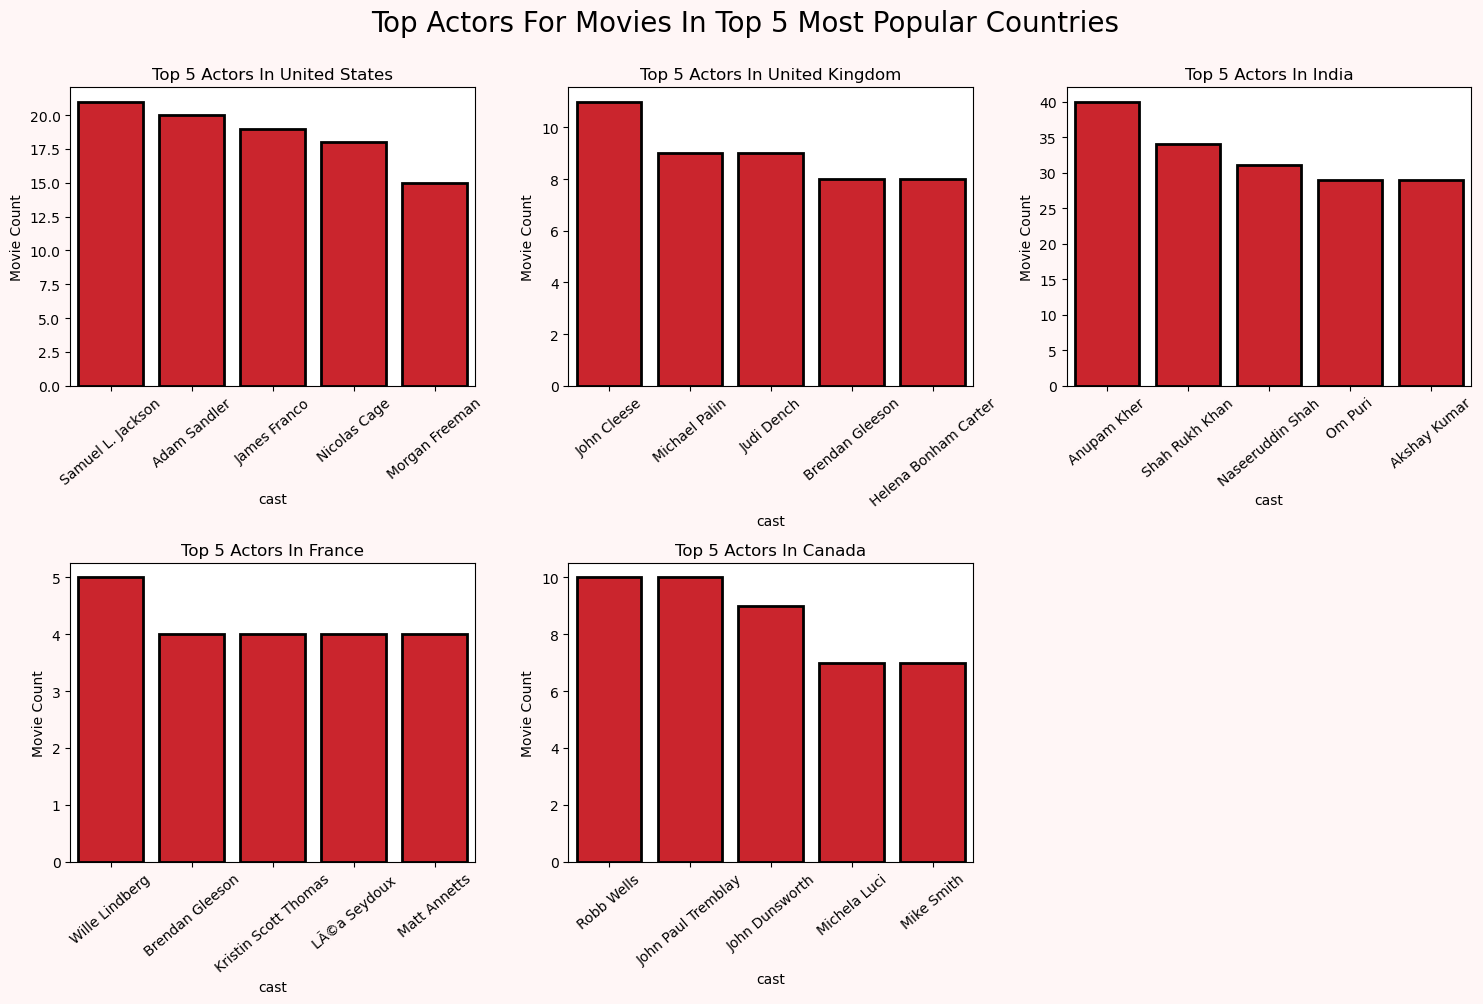

In [214]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United States
plt.subplot(2,3,1)
sns.barplot(x='cast', y='count', data=top_cast_movie_us_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('cast', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Actors In United States', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# United Kingdom
plt.subplot(2,3,2)
sns.barplot(x='cast', y='count', data=top_cast_movie_uk_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('cast', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Actors In United Kingdom', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# India
plt.subplot(2,3,3)
sns.barplot(x='cast', y='count', data=top_cast_movie_in_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('cast', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Actors In India', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# France
plt.subplot(2,3,4)
sns.barplot(x='cast', y='count', data=top_cast_movie_fr_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('cast', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Actors In France', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# Canada
plt.subplot(2,3,5)
sns.barplot(x='cast', y='count', data=top_cast_movie_cn_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('cast', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top 5 Actors In Canada', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

fig.suptitle('Top Actors For Movies In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insight:** Top 5 actors for the movie are identified for the top 5 countries. Details of the same will be available in the recommendations section.

## Top Actors and Directors For TV Shows In Top 5 Most Popular Countries

### Top 5 TV Show Directors

In [216]:
top_country_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added
5,s9,United Kingdom,TV Show,The Great British Baking Show,2021-09-24,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,September,2021
9,s16,United States,TV Show,Dear White People,2021-09-22,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,September,2021
16,s33,United Kingdom,TV Show,Sex Education,2021-09-17,2020,TV-MA,3,Insecure Otis has all the answers when it come...,2010s,September,2021
21,s41,United States,TV Show,He-Man and the Masters of the Universe,2021-09-16,2021,TV-Y7,1,Mighty teen Adam and his heroic squad of misfi...,2020s,September,2021
25,s56,United States,TV Show,Nailed It,2021-09-15,2021,TV-PG,6,Home bakers with a terrible track record take ...,2020s,September,2021


In [217]:
dir_df.head()

,show_id,director
0,s1,Kirsten Johnson
1,s2,Unknown Director
2,s3,Julien Leclercq
3,s4,Unknown Director
4,s5,Unknown Director


In [218]:
top_dir_tvs = top_country_tvs.merge(dir_df, on='show_id', how='inner')
top_dir_tvs = top_dir_tvs[top_dir_tvs['director'] != 'Unknown Director']
top_dir_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,director
0,s9,United Kingdom,TV Show,The Great British Baking Show,2021-09-24,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,September,2021,Andy Devonshire
39,s311,United States,TV Show,Cocaine Cowboys: The Kings of Miami,2021-04-08,2021,TV-MA,1,Two childhood friends go from high school drop...,2020s,April,2021,Billy Corben
46,s381,United States,TV Show,The Flash,2021-07-28,2021,TV-14,7,A forensics expert who wakes from a coma with ...,2020s,July,2021,Glen Winter
108,s677,United States,TV Show,Riverdale,2021-06-19,2019,TV-14,4,"While navigating the troubled waters of sex, r...",2010s,June,2021,Rob Seidenglanz
113,s682,United Kingdom,TV Show,They've Gotta Have Us,2021-06-19,2018,TV-MA,1,Powered by candid recollections from esteemed ...,2010s,June,2021,Simon Frederick


In [226]:
# United Kingdom
top_dir_tvs_uk = top_dir_tvs.loc[top_dir_tvs['country'] == 'United Kingdom']
top_dir_tvs_uk.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,director
0,s9,United Kingdom,TV Show,The Great British Baking Show,2021-09-24,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,September,2021,Andy Devonshire
113,s682,United Kingdom,TV Show,They've Gotta Have Us,2021-06-19,2018,TV-MA,1,Powered by candid recollections from esteemed ...,2010s,June,2021,Simon Frederick
126,s759,United Kingdom,TV Show,Feel Good,2021-04-06,2021,TV-MA,2,Stand-up comic Mae Martin navigates a passiona...,2020s,April,2021,Ally Pankiw
278,s1420,United Kingdom,TV Show,Last Tango in Halifax,2021-12-01,2020,TV-MA,4,Two widowed childhood sweethearts fall for eac...,2010s,December,2021,Juliet May
290,s1464,United Kingdom,TV Show,The Cat in the Hat Knows a Lot About That!,2021-01-01,2014,TV-Y,1,"The Cat in the Hat is back â€“ and this time, ...",2010s,January,2021,Tony Collingwood


In [227]:
top_dir_tvs_uk_count = top_dir_tvs_uk.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_tvs_uk_count.reset_index(inplace=True)
top_dir_tvs_uk_count = top_dir_tvs_uk_count.head()
top_dir_tvs_uk_count

,director,count
0,Alastair Fothergill,3
1,Alan Poul,1
2,Toby Haynes,1
3,Simon Frederick,1
4,Rachel Bell,1


In [228]:
# United States
top_dir_tvs_us = top_dir_tvs.loc[top_dir_tvs['country'] == 'United States']
top_dir_tvs_us_count = top_dir_tvs_us.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_tvs_us_count.reset_index(inplace=True)
top_dir_tvs_us_count = top_dir_tvs_us_count.head()
top_dir_tvs_us_count

,director,count
0,Ken Burns,3
1,Stan Lathan,2
2,Joe Berlinger,2
3,Rob Seidenglanz,2
4,Lynn Novick,2


In [234]:
# Japan
top_dir_tvs_jp = top_dir_tvs.loc[top_dir_tvs['country'] == 'Japan']
top_dir_tvs_jp_count = top_dir_tvs_jp.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_tvs_jp_count.reset_index(inplace=True)
top_dir_tvs_jp_count = top_dir_tvs_jp_count.head()
top_dir_tvs_jp_count

,director,count
0,Caroline SÃ¡,1
1,Kobun Shizuno,1
2,Tsutomu Mizushima,1
3,Thomas Astruc,1
4,Tensai Okamura,1


In [236]:
# South Korea
top_dir_tvs_sk = top_dir_tvs.loc[top_dir_tvs['country'] == 'South Korea']
top_dir_tvs_sk_count = top_dir_tvs_sk.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_dir_tvs_sk_count.reset_index(inplace=True)
top_dir_tvs_sk_count = top_dir_tvs_sk_count.head()
top_dir_tvs_sk_count

,director,count
0,Jung-ah Im,2
1,Shin Won-ho,2
2,Chang-Min Lee,1
3,Hong Won-ki,1
4,Jeon Go-woon,1


In [237]:
# Canada
top_cast_tvs_cn = top_dir_tvs.loc[top_dir_tvs['country'] == 'Canada']
top_cast_tvs_cn_count = top_cast_tvs_cn.groupby('director').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_tvs_cn_count.reset_index(inplace=True)
top_cast_tvs_cn_count = top_cast_tvs_cn_count.head()
top_cast_tvs_cn_count

,director,count
0,Alastair Fothergill,1
1,Gary Howsam,1
2,Guy Vasilovich,1
3,John Paul Tremblay,1
4,Kyran Kelly,1


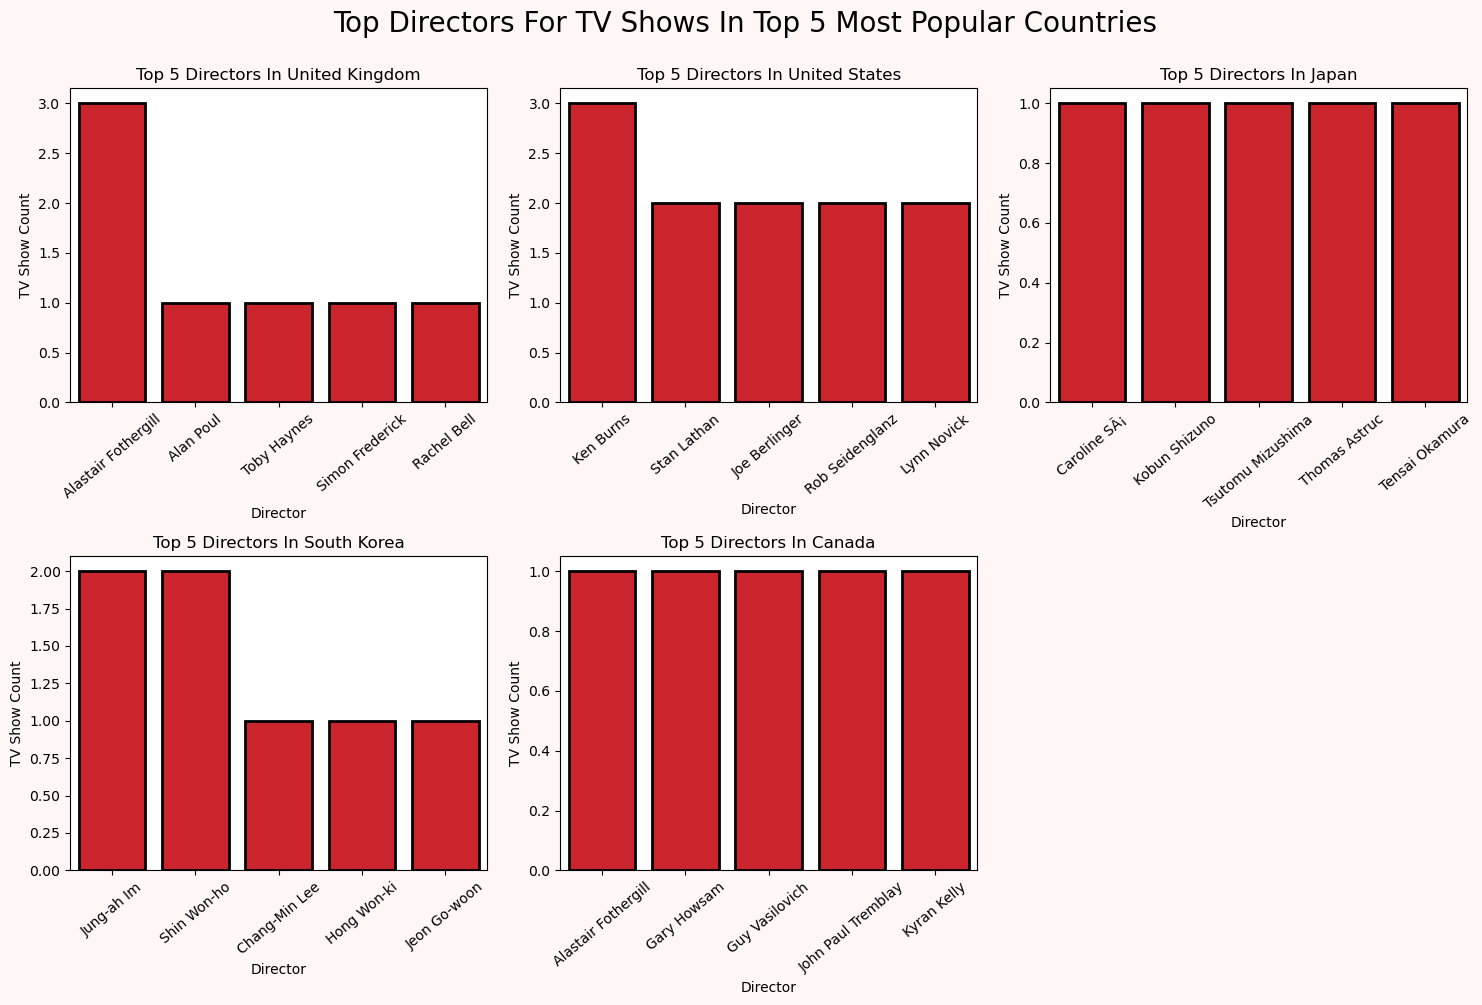

In [238]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United Kingdom
plt.subplot(2,3,1)
sns.barplot(x='director', y='count', data=top_dir_tvs_uk_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Directors In United Kingdom', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# United States
plt.subplot(2,3,2)
sns.barplot(x='director', y='count', data=top_dir_tvs_us_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Directors In United States', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# Japan
plt.subplot(2,3,3)
sns.barplot(x='director', y='count', data=top_dir_tvs_jp_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Directors In Japan', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# South Korea
plt.subplot(2,3,4)
sns.barplot(x='director', y='count', data=top_dir_tvs_sk_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Directors In South Korea', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# Canada
plt.subplot(2,3,5)
sns.barplot(x='director', y='count', data=top_cast_tvs_cn_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Director', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Directors In Canada', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

fig.suptitle('Top Directors For TV Shows In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insight:** Top 5 directors for the TV Shows are identified for the top 5 countries. Details of the same will be available in the recommendations section.

### Top 5 TV Show Actors

In [241]:
top_cast_tvs = top_country_tvs.merge(cast_df, on='show_id', how='inner')
top_cast_tvs = top_cast_tvs[top_cast_tvs['cast'] != 'Unknown Actor']
top_cast_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,cast
0,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,Mel Giedroyc
1,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,Sue Perkins
2,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,Mary Berry
3,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s,Paul Hollywood
4,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,Logan Browning


In [244]:
# United Kingdom
top_cast_tvs_uk = top_cast_tvs.loc[top_cast_tvs['country'] == 'United Kingdom']
top_cast_tvs_uk_count = top_cast_tvs_uk.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_tvs_uk_count.reset_index(inplace=True)
top_cast_tvs_uk_count = top_cast_tvs_uk_count.head()
top_cast_tvs_uk_count

,cast,count
0,David Attenborough,13
1,Eric Idle,5
2,Michael Palin,5
3,Terry Jones,5
4,John Cleese,5


In [245]:
# United States
top_cast_tvs_us = top_cast_tvs.loc[top_cast_tvs['country'] == 'United States']
top_cast_tvs_us.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,cast
4,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,Logan Browning
5,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,Brandon P. Bell
6,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,DeRon Horton
7,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,Antoinette Robertson
8,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s,John Patrick Amedori


In [246]:
top_cast_tvs_us_count = top_cast_tvs_us.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_tvs_us_count.reset_index(inplace=True)
top_cast_tvs_us_count = top_cast_tvs_us_count.head()
top_cast_tvs_us_count

,cast,count
0,Grey Griffin,10
1,Vincent Tong,8
2,Johnny Yong Bosch,7
3,Mike Colter,7
4,Steven Yeun,7


In [248]:
# Japan
top_cast_tvs_jp = top_cast_tvs.loc[top_cast_tvs['country'] == 'Japan']
top_cast_tvs_jp_count = top_cast_tvs_jp.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_tvs_jp_count.reset_index(inplace=True)
top_cast_tvs_jp_count = top_cast_tvs_jp_count.head()
top_cast_tvs_jp_count

,cast,count
0,Takahiro Sakurai,22
1,Yuki Kaji,18
2,Daisuke Ono,17
3,Junichi Suwabe,16
4,Ai Kayano,16


In [250]:
# South Korea
top_cast_tvs_fr = top_cast_tvs.loc[top_cast_tvs['country'] == 'South Korea']
top_cast_tvs_sk_count = top_cast_tvs_fr.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_tvs_sk_count.reset_index(inplace=True)
top_cast_tvs_sk_count = top_cast_tvs_sk_count.head()
top_cast_tvs_sk_count

,cast,count
0,Sung Dong-il,5
1,Kim Won-hae,5
2,Cho Seong-ha,5
3,Kim Sun-young,4
4,Lee Il-hwa,4


In [251]:
# Canada
top_cast_tvs_cn = top_cast_tvs.loc[top_cast_tvs['country'] == 'Canada']
top_cast_tvs_cn_count = top_cast_tvs_cn.groupby('cast').aggregate(count = ('show_id', 'count')).sort_values(by = 'count', ascending=False)
top_cast_tvs_cn_count.reset_index(inplace=True)
top_cast_tvs_cn_count = top_cast_tvs_cn_count.head()
top_cast_tvs_cn_count

,cast,count
0,Ashleigh Ball,7
1,Vincent Tong,6
2,Brian Drummond,5
3,Andrea Libman,5
4,Michela Luci,4


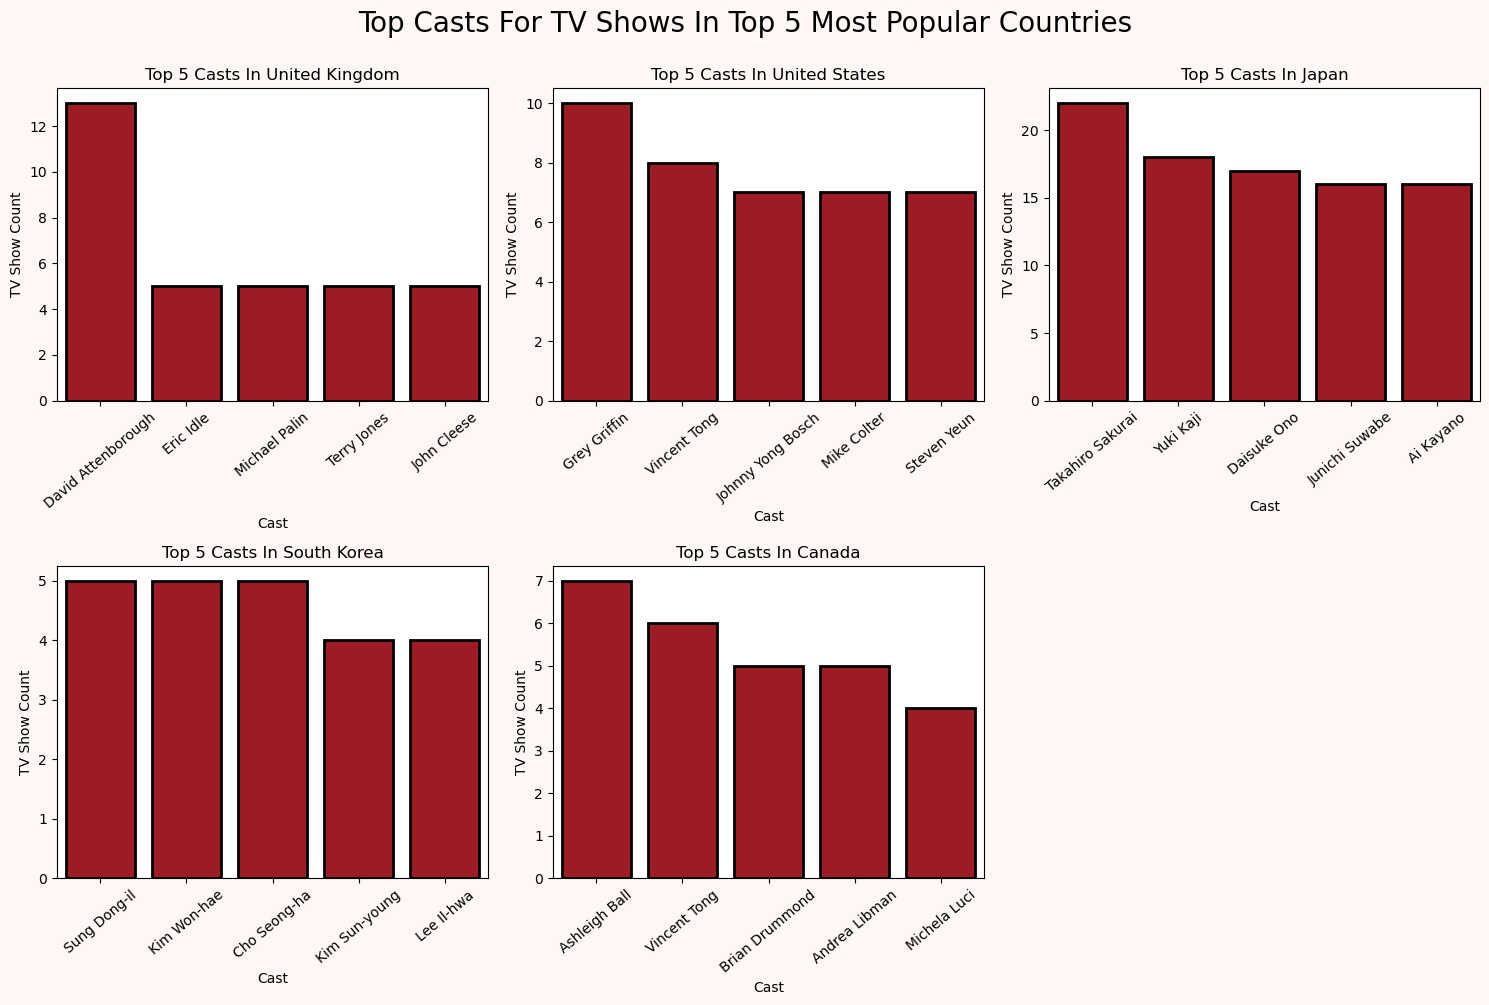

In [253]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United Kingdom
plt.subplot(2,3,1)
sns.barplot(x='cast', y='count', data=top_cast_tvs_uk_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Cast', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Casts In United Kingdom', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# United States
plt.subplot(2,3,2)
sns.barplot(x='cast', y='count', data=top_cast_tvs_us_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Cast', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Casts In United States', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# Japan
plt.subplot(2,3,3)
sns.barplot(x='cast', y='count', data=top_cast_tvs_jp_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Cast', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Casts In Japan', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# South Korea
plt.subplot(2,3,4)
sns.barplot(x='cast', y='count', data=top_cast_tvs_sk_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Cast', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Casts In South Korea', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

# Canada
plt.subplot(2,3,5)
sns.barplot(x='cast', y='count', data=top_cast_tvs_cn_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Cast', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top 5 Casts In Canada', fontsize=12)
plt.xticks(rotation=40, fontsize=10)

fig.suptitle('Top Casts For TV Shows In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insight:** Top 5 actors for the TV Shows are identified for the top 5 countries. Details of the same will be available in the recommendations section.

## Movie Ratings in Top 5 Countries

In [254]:
top_country_mv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September,2021
2,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021
5,s8,United Kingdom,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021
8,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September,2021
16,s25,India,Movie,Jeans,2021-09-21,1998,TV-14,166,When the father of the man she loves insists t...,1990s,September,2021


In [258]:
# United States
rating_us = top_country_mv[top_country_mv['country'] == 'United States']
rating_us_count = rating_us['rating'].value_counts().reset_index(name='count')
rating_us_count

,index,count
0,TV-MA,719
1,R,660
2,PG-13,433
3,TV-14,276
4,PG,243
5,TV-PG,180
6,TV-Y7,55
7,TV-Y,52
8,TV-G,47
9,NR,41


In [259]:
# United Kingdom
rating_uk = top_country_mv[top_country_mv['country'] == 'United Kingdom']
rating_uk_count = rating_uk['rating'].value_counts().reset_index(name='count')
rating_uk_count

,index,count
0,R,145
1,TV-MA,138
2,PG-13,84
3,TV-14,58
4,TV-PG,41
5,PG,35
6,TV-G,10
7,NR,10
8,TV-Y,5
9,G,4


In [260]:
# India
rating_in = top_country_mv[top_country_mv['country'] == 'India']
rating_in_count = rating_in['rating'].value_counts().reset_index(name='count')
rating_in_count

,index,count
0,TV-14,547
1,TV-MA,232
2,TV-PG,133
3,TV-Y7,12
4,PG-13,11
5,PG,7
6,TV-G,7
7,NR,7
8,R,5
9,TV-Y7-FV,1


In [261]:
# France
rating_fr = top_country_mv[top_country_mv['country'] == 'France']
rating_fr_count = rating_fr['rating'].value_counts().reset_index(name='count')
rating_fr_count

,index,count
0,TV-MA,120
1,R,57
2,TV-14,45
3,PG-13,35
4,PG,21
5,TV-PG,9
6,NR,4
7,TV-Y7,3
8,TV-G,3
9,G,2


In [267]:
# Canada
rating_cn = top_country_mv[top_country_mv['country'] == 'Canada']
rating_cn_count = rating_cn['rating'].value_counts().reset_index(name='count')
rating_cn_count

,index,count
0,R,79
1,TV-MA,72
2,PG,33
3,PG-13,32
4,TV-14,29
5,TV-PG,25
6,TV-Y,25
7,TV-Y7,8
8,TV-G,8
9,NR,5


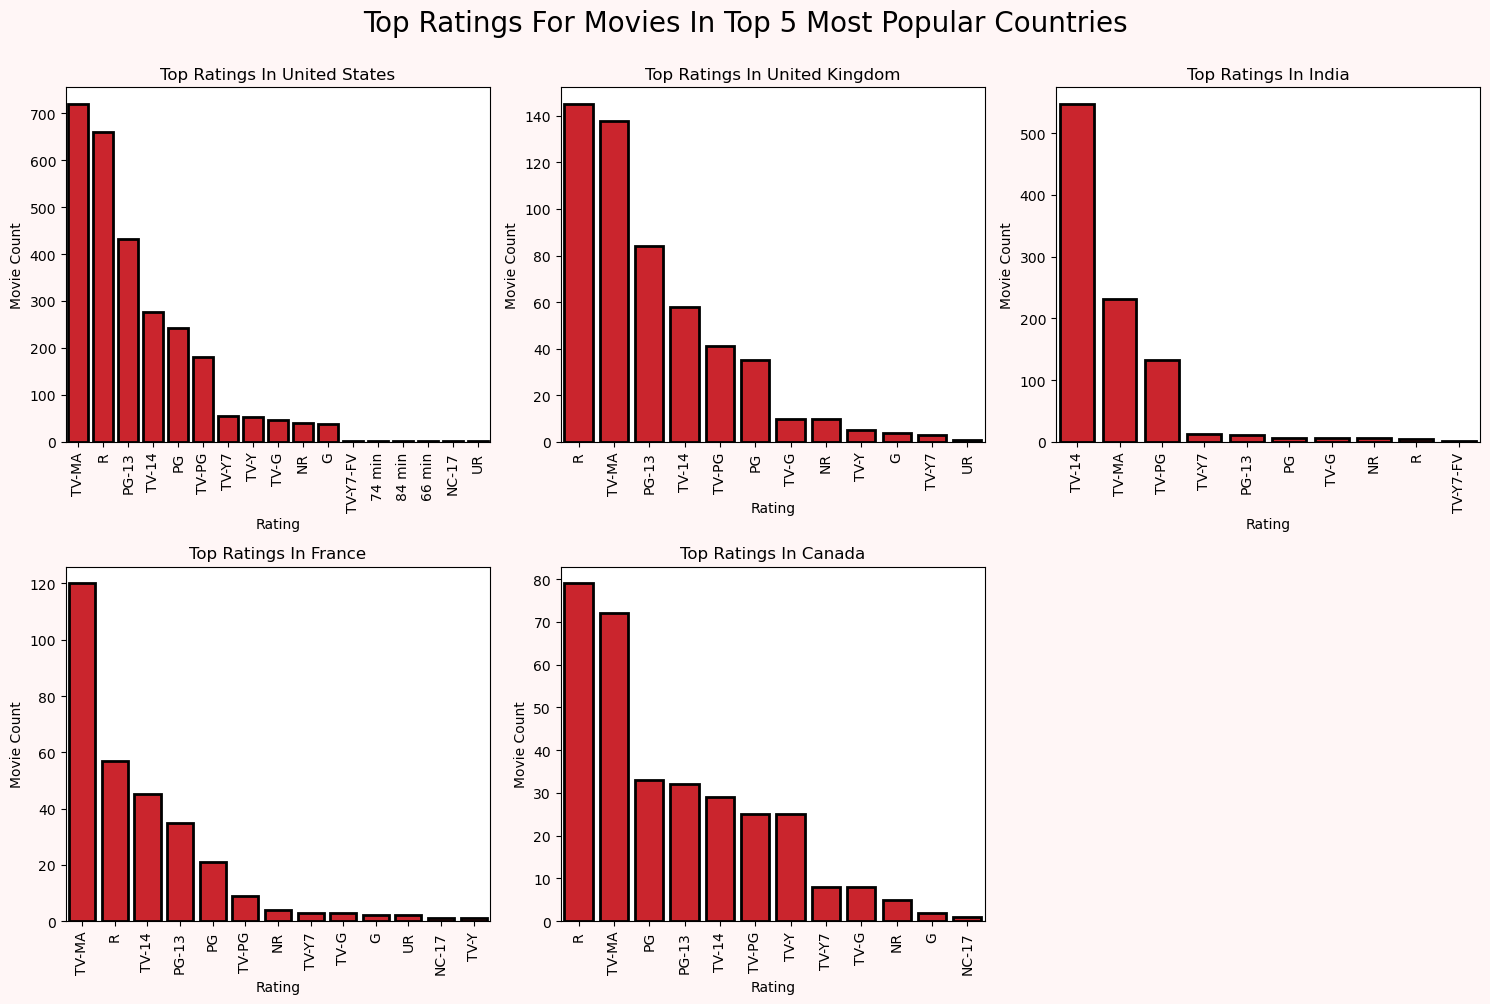

In [376]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United States
plt.subplot(2,3,1)
sns.barplot(x='index', y='count', data=rating_us_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top Ratings In United States', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# United Kingdom
plt.subplot(2,3,2)
sns.barplot(x='index', y='count', data=rating_uk_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top Ratings In United Kingdom', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# India
plt.subplot(2,3,3)
sns.barplot(x='index', y='count', data=rating_in_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top Ratings In India', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# France
plt.subplot(2,3,4)
sns.barplot(x='index', y='count', data=rating_fr_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top Ratings In France', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Canada
plt.subplot(2,3,5)
sns.barplot(x='index', y='count', data=rating_cn_count, color=netflix[0], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Top Ratings In Canada', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

fig.suptitle('Top Ratings For Movies In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insights:** 
- TV-MA is the most popylar rating in 3 out of 5 countries.
- Except India which has a very few number of R-rated movies, R-rated movies are popular in all top countries.
- India has most number of TV-14 movies.

## TV Show Ratings in Top 5 Countries

In [274]:
top_country_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
5,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s
9,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s
16,s33,United Kingdom,TV Show,Sex Education,17-09-2021,2020,TV-MA,3,Insecure Otis has all the answers when it come...,2010s
21,s41,United States,TV Show,He-Man and the Masters of the Universe,16-09-2021,2021,TV-Y7,1,Mighty teen Adam and his heroic squad of misfi...,2020s
25,s56,United States,TV Show,Nailed It,15-09-2021,2021,TV-PG,6,Home bakers with a terrible track record take ...,2020s


In [276]:
# United Kingdom
rating_uk_tv = top_country_tvs[top_country_tvs['country'] == 'United Kingdom']
rating_uk_tv_count = rating_uk_tv['rating'].value_counts().reset_index(name='count')
rating_uk_tv_count

,index,count
0,TV-MA,115
1,TV-PG,57
2,TV-14,45
3,TV-Y,29
4,TV-G,15
5,TV-Y7,9
6,NR,2


In [275]:
# United States
rating_us_tv = top_country_tvs[top_country_tvs['country'] == 'United States']
rating_us_tv_count = rating_us_tv['rating'].value_counts().reset_index(name='count')
rating_us_tv_count

,index,count
0,TV-MA,382
1,TV-14,221
2,TV-PG,124
3,TV-Y7,92
4,TV-Y,75
5,TV-G,42
6,NR,2


In [277]:
# Japan
rating_jp_tv = top_country_tvs[top_country_tvs['country'] == 'Japan']
rating_jp_tv_count = rating_jp_tv['rating'].value_counts().reset_index(name='count')
rating_jp_tv_count

,index,count
0,TV-14,76
1,TV-MA,69
2,TV-Y7,27
3,TV-PG,22
4,TV-Y,2
5,TV-G,2
6,Unknown Rating,1


In [278]:
# South Korea
rating_sk_tv = top_country_tvs[top_country_tvs['country'] == 'South Korea']
rating_sk_tv_count = rating_sk_tv['rating'].value_counts().reset_index(name='count')
rating_sk_tv_count

,index,count
0,TV-14,82
1,TV-MA,55
2,TV-PG,15
3,TV-Y7,9
4,TV-Y,8
5,TV-G,1


In [279]:
# Canada
rating_cn_tv = top_country_tvs[top_country_tvs['country'] == 'Canada']
rating_cn_tv_count = rating_cn_tv['rating'].value_counts().reset_index(name='count')
rating_cn_tv_count

,index,count
0,TV-MA,35
1,TV-Y7,27
2,TV-Y,20
3,TV-14,20
4,TV-PG,14
5,TV-G,9
6,TV-Y7-FV,1


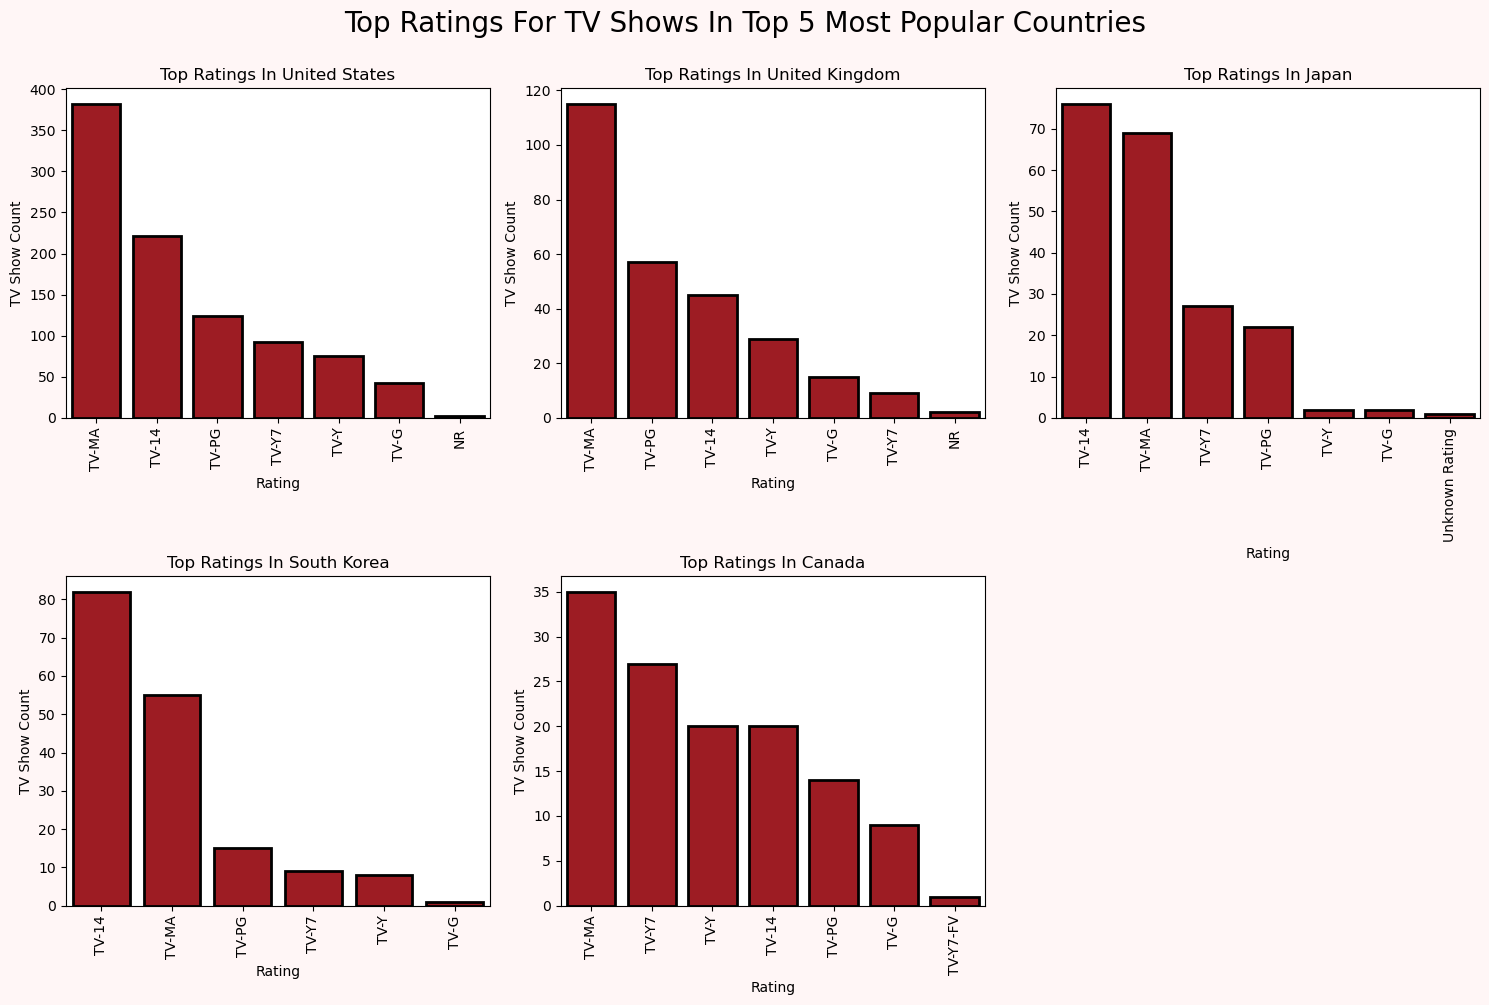

In [377]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United Kingdom
plt.subplot(2,3,2)
sns.barplot(x='index', y='count', data=rating_uk_tv_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top Ratings In United Kingdom', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# United States
plt.subplot(2,3,1)
sns.barplot(x='index', y='count', data=rating_us_tv_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top Ratings In United States', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Japan
plt.subplot(2,3,3)
sns.barplot(x='index', y='count', data=rating_jp_tv_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top Ratings In Japan', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# South Korea
plt.subplot(2,3,4)
sns.barplot(x='index', y='count', data=rating_sk_tv_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top Ratings In South Korea', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Canada
plt.subplot(2,3,5)
sns.barplot(x='index', y='count', data=rating_cn_tv_count, color=netflix[1], edgecolor='black', linewidth=2)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Top Ratings In Canada', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

fig.suptitle('Top Ratings For TV Shows In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insights:** TV-MA and TV-14 are the most popular ratings for TV Shows on Netflix Platform.

## Seasonal Content Strategy in Top 5 Countries - Movies

In [281]:
top_country_mv.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added
0,s1,United States,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,"As her father nears the end of his life, filmm...",2010s,September,2021
2,s8,United States,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021
5,s8,United Kingdom,Movie,Sankofa,2021-09-24,1993,TV-MA,125,"On a photo shoot in Ghana, an American model s...",1990s,September,2021
8,s10,United States,Movie,The Starling,2021-09-24,2021,PG-13,104,A woman adjusting to life after a loss contend...,2020s,September,2021
16,s25,India,Movie,Jeans,2021-09-21,1998,TV-14,166,When the father of the man she loves insists t...,1990s,September,2021


In [287]:
#Extracting Quarters
top_country_mv['quarter'] = top_country_mv['date_added'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})
top_country_mv.sample(10)

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,month_added,year_added,quarter
2259,s2727,India,Movie,Hasee Toh Phasee,2020-01-04,2014,TV-14,135,Nikhil is tasked with keeping his fiancÃ©e's t...,2010s,January,2020,Q1
7462,s8487,United States,Movie,The Ring,2020-01-01,2002,PG-13,116,A reporter watches a video that supposedly set...,2000s,January,2020,Q1
3962,s4976,India,Movie,Secret Superstar,2018-03-23,2017,TV-14,150,A talented teenage singer-songwriter living am...,2010s,March,2018,Q1
4778,s5984,United States,Movie,100 Years: One Woman's Fight for Justice,2018-03-20,2016,TV-14,75,This documentary chronicles Elouise Cobell's l...,2010s,March,2018,Q1
5860,s6996,United States,Movie,Hope: One in a Billion,2019-12-15,2017,TV-14,81,"The remarkable true story of Gift Ngoepe, the ...",2010s,December,2019,Q4
2280,s2755,United States,Movie,Greater,2020-03-31,2016,PG,131,Faith and determination transform a talentless...,2010s,March,2020,Q1
6260,s7381,India,Movie,Mahabharat,2018-01-08,2013,TV-14,119,Two young brothers encounter a singing bird wh...,2010s,January,2018,Q1
7113,s8198,Canada,Movie,The Assignment,2020-03-15,2016,R,95,A hitman has his body surgically altered into ...,2010s,March,2020,Q1
6098,s7219,United States,Movie,Knock Knock,2020-01-11,2015,R,99,A devoted husband and father on his own for th...,2010s,January,2020,Q1
3846,s4864,United States,Movie,Ali Wong: Hard Knock Wife,2018-05-13,2018,TV-MA,64,"Two years after the hit ""Baby Cobra,"" Ali Wong...",2010s,May,2018,Q2


In [309]:
# United States
quarter_movie_us = top_country_mv[top_country_mv['country'] == 'United States']
quarter_movie_us_count = quarter_movie_us.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_movie_us_count

,quarter,count
0,Q1,1373
1,Q2,438
2,Q3,465
3,Q4,476


In [310]:
# United Kingdom
quarter_movie_uk = top_country_mv[top_country_mv['country'] == 'United Kingdom']
quarter_movie_uk_count = quarter_movie_fr_count = quarter_movie_uk.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_movie_uk_count

,quarter,count
0,Q1,266
1,Q2,83
2,Q3,89
3,Q4,96


In [311]:
# India
quarter_movie_in = top_country_mv[top_country_mv['country'] == 'India']
quarter_movie_in_count = quarter_movie_fr_count = quarter_movie_in.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_movie_in_count

,quarter,count
0,Q1,499
1,Q2,146
2,Q3,125
3,Q4,192


In [308]:
# France
quarter_movie_fr = top_country_mv[top_country_mv['country'] == 'France']
quarter_movie_fr_count = quarter_movie_fr.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_movie_fr_count

,quarter,count
0,Q1,131
1,Q2,49
2,Q3,54
3,Q4,69


In [312]:
# Canada
quarter_movie_cn = top_country_mv[top_country_mv['country'] == 'Canada']
quarter_movie_cn_count = quarter_movie_fr_count = quarter_movie_cn.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_movie_cn_count

,quarter,count
0,Q1,137
1,Q2,59
2,Q3,62
3,Q4,61


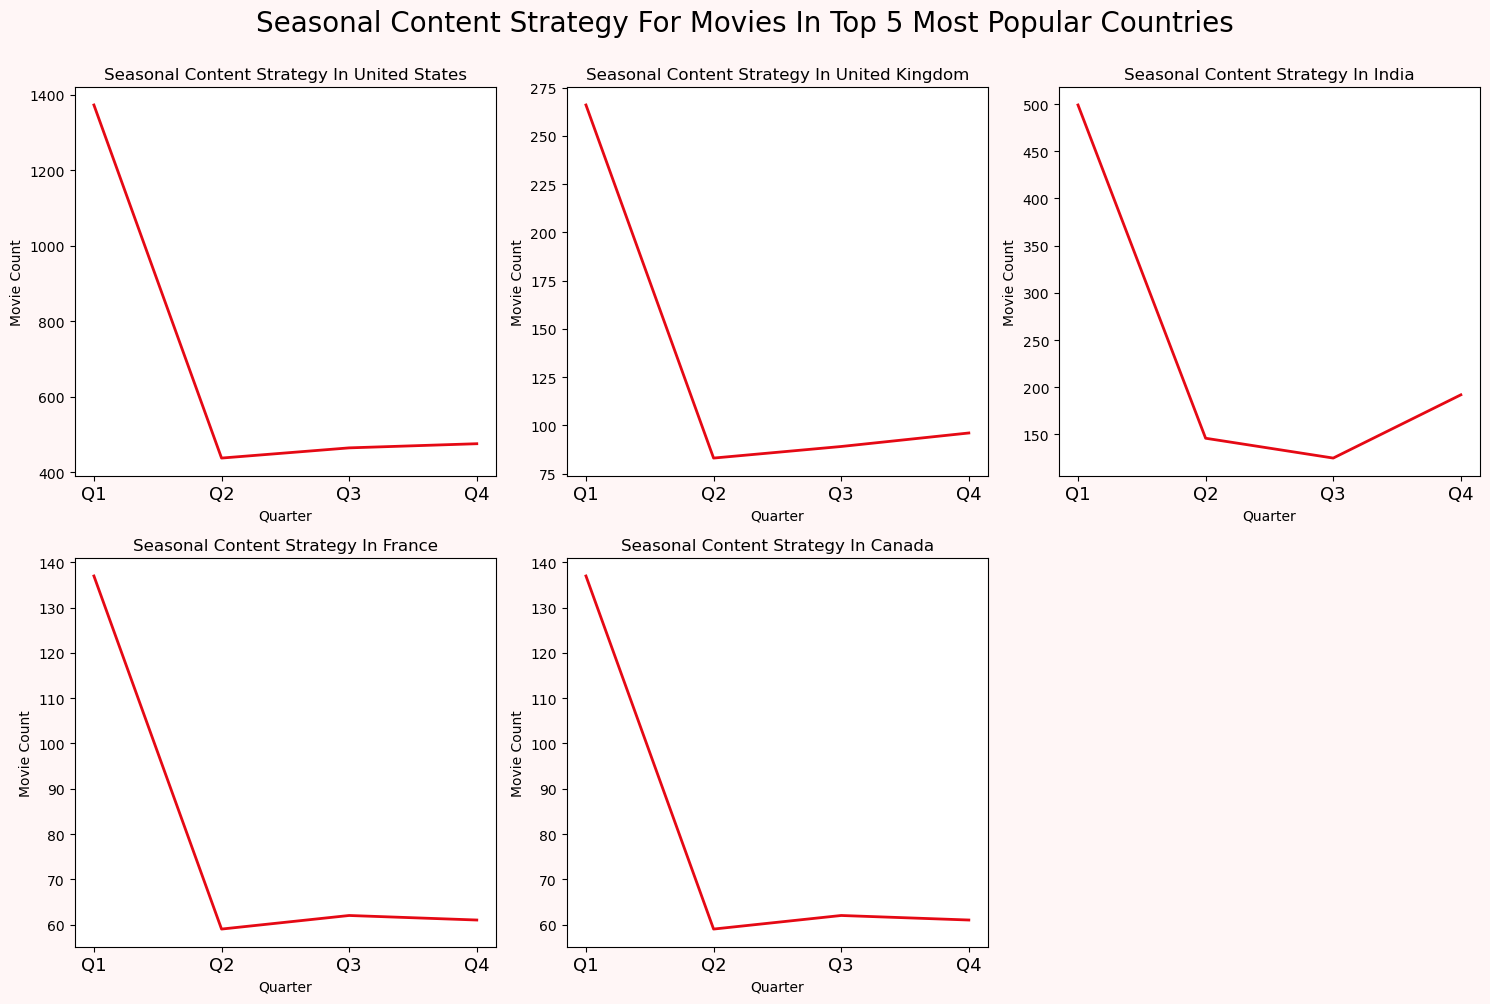

In [316]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United States
plt.subplot(2,3,1)
sns.lineplot(x='quarter', y='count', data=quarter_movie_us_count, color=netflix[0], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Seasonal Content Strategy In United States', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# United Kingdom
plt.subplot(2,3,2)
sns.lineplot(x='quarter', y='count', data=quarter_movie_uk_count, color=netflix[0], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Seasonal Content Strategy In United Kingdom', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# India
plt.subplot(2,3,3)
sns.lineplot(x='quarter', y='count', data=quarter_movie_in_count, color=netflix[0], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Seasonal Content Strategy In India', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# France
plt.subplot(2,3,4)
sns.lineplot(x='quarter', y='count', data=quarter_movie_fr_count, color=netflix[0], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Seasonal Content Strategy In France', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# Canada
plt.subplot(2,3,5)
sns.lineplot(x='quarter', y='count', data=quarter_movie_cn_count, color=netflix[0], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Movie Count', fontsize=10)
plt.title('Seasonal Content Strategy In Canada', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

fig.suptitle('Seasonal Content Strategy For Movies In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insights:** Q1 is the most busy month for top 5 countries.

## Seasonal Content Strategy in Top 5 Countries - TV Shows

In [317]:
top_country_tvs.head()

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade
5,s9,United Kingdom,TV Show,The Great British Baking Show,24-09-2021,2021,TV-14,9,A talented batch of amateur bakers face off in...,2020s
9,s16,United States,TV Show,Dear White People,22-09-2021,2021,TV-MA,4,Students of color navigate the daily slights a...,2020s
16,s33,United Kingdom,TV Show,Sex Education,17-09-2021,2020,TV-MA,3,Insecure Otis has all the answers when it come...,2010s
21,s41,United States,TV Show,He-Man and the Masters of the Universe,16-09-2021,2021,TV-Y7,1,Mighty teen Adam and his heroic squad of misfi...,2020s
25,s56,United States,TV Show,Nailed It,15-09-2021,2021,TV-PG,6,Home bakers with a terrible track record take ...,2020s


In [321]:
top_country_tvs['date_added'] = pd.to_datetime(top_country_tvs['date_added'])
top_country_tvs['date_added'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1705 entries, 5 to 3027
Series name: date_added
Non-Null Count  Dtype         
--------------  -----         
1697 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 26.6 KB


In [322]:
#Extracting Quarters
top_country_tvs['quarter'] = top_country_tvs['date_added'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})
top_country_tvs.sample(10)

,show_id,country,type,title,date_added,release_year,rating,duration,description,decade,quarter
1267,s3209,Canada,TV Show,Chip and Potato,2019-11-29,2019,TV-Y,2,"Lovable pug Chip starts kindergarten, makes ne...",2010s,Q4
1296,s3271,South Korea,TV Show,Inheritors,2019-11-15,2013,TV-14,1,"After a chance encounter in LA, two teens from...",2010s,Q4
1861,s4635,Canada,TV Show,Transformers: Rescue Bots,2018-09-19,2016,TV-Y7,1,Follow the adventure of four young transformer...,2010s,Q3
1068,s2762,South Korea,TV Show,Rugal,2020-03-29,2020,TV-MA,1,A police detective who loses everything to a c...,2010s,Q1
2410,s6292,Japan,TV Show,Beyblade: Metal Fusion,2017-12-15,2009,TV-Y7,1,"In this anime adventure series for kids, the f...",2000s,Q4
216,s545,Canada,TV Show,Workin' Moms,2021-07-06,2021,TV-MA,5,Maternity leave is over and it's time for thes...,2020s,Q3
2474,s6533,United States,TV Show,Cooking on High,2018-06-22,2018,TV-MA,1,In the first-ever competitive cannabis cooking...,2010s,Q2
307,s764,United States,TV Show,Sweet Tooth,2021-06-04,2021,TV-14,1,On a perilous adventure across a post-apocalyp...,2020s,Q2
2101,s5237,Japan,TV Show,Beyblade Burst,2017-10-01,2016,TV-Y7,1,"Middle schooler Valt Aoi, with his Beyblade Va...",2010s,Q4
1099,s2822,South Korea,TV Show,Kingdom,2020-03-13,2020,TV-MA,2,While strange rumors about their ill king grip...,2010s,Q1


In [324]:
# United Kingdom
quarter_tvs_uk = top_country_tvs[top_country_tvs['country'] == 'United Kingdom']
quarter_tvs_uk_count = quarter_tvs_fr_count = quarter_tvs_uk.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_tvs_uk_count

,quarter,count
0,Q1,79
1,Q2,49
2,Q3,76
3,Q4,67


In [325]:
# United States
quarter_tvs_us = top_country_tvs[top_country_tvs['country'] == 'United States']
quarter_tvs_us_count = quarter_tvs_us.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_tvs_us_count

,quarter,count
0,Q1,228
1,Q2,210
2,Q3,251
3,Q4,243


In [326]:
# Japan
quarter_tvs_jp = top_country_tvs[top_country_tvs['country'] == 'Japan']
quarter_tvs_jp_count = quarter_movie_fr_count = quarter_tvs_jp.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_tvs_jp_count

,quarter,count
0,Q1,47
1,Q2,52
2,Q3,45
3,Q4,54


In [327]:
# South Korea
quarter_tvs_sk = top_country_tvs[top_country_tvs['country'] == 'South Korea']
quarter_tvs_sk_count = quarter_tvs_sk.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_tvs_sk_count

,quarter,count
0,Q1,36
1,Q2,47
2,Q3,36
3,Q4,51


In [328]:
# Canada
quarter_tvs_cn = top_country_tvs[top_country_tvs['country'] == 'Canada']
quarter_tvs_cn_count = quarter_movie_fr_count = quarter_tvs_cn.groupby('quarter').aggregate(count = ('title', 'count')).reset_index()
quarter_tvs_cn_count

,quarter,count
0,Q1,27
1,Q2,34
2,Q3,30
3,Q4,35


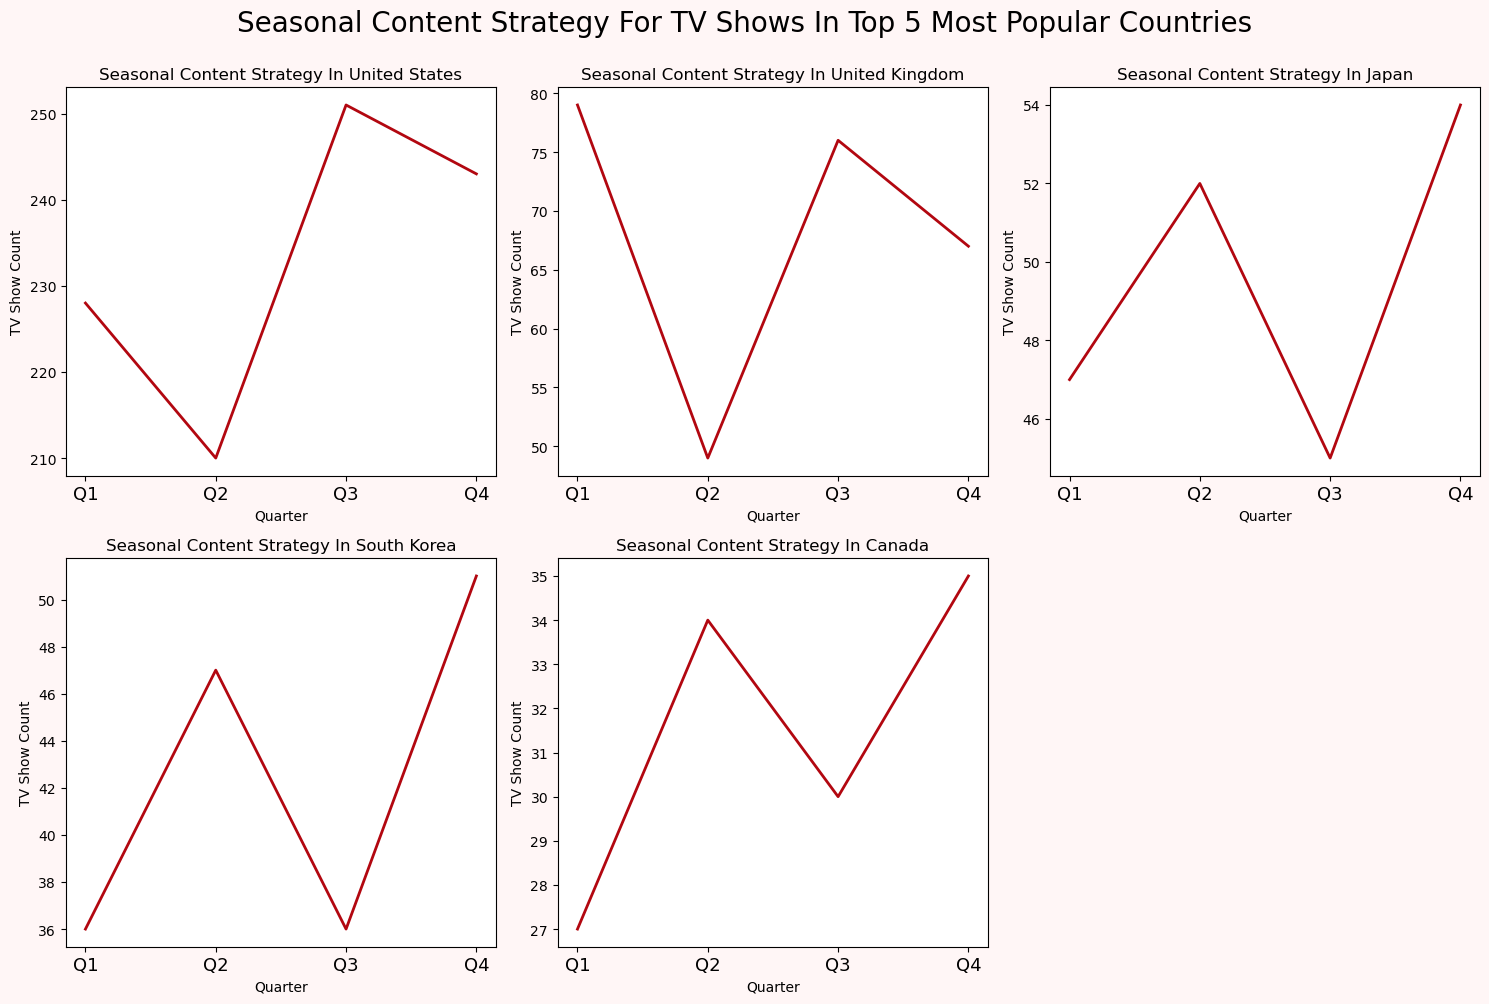

In [331]:
# Plotting Subplot
fig = plt.figure(figsize=(15,10), facecolor='#FFF6F6', edgecolor='black')

# United Kingdom
plt.subplot(2,3,2)
sns.lineplot(x='quarter', y='count', data=quarter_tvs_uk_count, color=netflix[1], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Seasonal Content Strategy In United Kingdom', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# United States
plt.subplot(2,3,1)
sns.lineplot(x='quarter', y='count', data=quarter_tvs_us_count, color=netflix[1], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Seasonal Content Strategy In United States', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# Japan
plt.subplot(2,3,3)
sns.lineplot(x='quarter', y='count', data=quarter_tvs_jp_count, color=netflix[1], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Seasonal Content Strategy In Japan', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# South Korea
plt.subplot(2,3,4)
sns.lineplot(x='quarter', y='count', data=quarter_tvs_sk_count, color=netflix[1], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Seasonal Content Strategy In South Korea', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

# Canada
plt.subplot(2,3,5)
sns.lineplot(x='quarter', y='count', data=quarter_tvs_cn_count, color=netflix[1], linewidth=2)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('TV Show Count', fontsize=10)
plt.title('Seasonal Content Strategy In Canada', fontsize=12)
plt.xticks(rotation=0, fontsize=13)

fig.suptitle('Seasonal Content Strategy For TV Shows In Top 5 Most Popular Countries', fontsize=20, y=1)
plt.tight_layout()
plt.show()

**Insights:** Q3 is the most busy month for top 5 countries.